In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import numba

from sample_processing import *
from gibbs_sampler import *
%load_ext autoreload
%autoreload 2

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/912227337.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def calc_c_vals(cluster_sol, similarity_mat):
    
    c_vals = np.zeros(len(cluster_sol))
    for i in range(len(cluster_sol)):

        point_clust = cluster_sol[i]
        point_sims = similarity_mat[i]

        neighbs = np.where(cluster_sol==point_clust)[0]
        neighbs_sim = point_sims[neighbs]
        c_val_i = np.mean(neighbs_sim)
        c_vals[i] = c_val_i
        
        return c_vals
    
def confidence_matrix(cluster_sol, similarity_mat):
    
    # Get names of clusters
    sorted_clust_names = pd.Series(cluster_sol).value_counts().index

    # Re-arrange IDs and form new sorted similarity matrix
    arranged_ids = []
    for c in sorted_clust_names:

        clust_ids = np.where(cluster_sol==c)[0]
        c_vals_clust = c_vals[clust_ids]
        sorted_clust_ids =clust_ids[np.argsort(c_vals_clust)[::-1]]

        arranged_ids.append(sorted_clust_ids)

    arranged_ids = np.concatenate(arranged_ids)

    sorted_matrix = np.zeros((len(cluster_sol),len(cluster_sol)))

    for i in range(len(cluster_sol)):
        for j in range(len(cluster_sol)):

            sorted_matrix[i,j] = sim_mat[arranged_ids[i], arranged_ids[j]]

# Prelim on Wildfire Data

In [3]:
# Create a StringIO object to simulate reading from a file-like object
from io import StringIO


def extract_state(input_string):
    # Use regular expression to extract text between five asterisks
    result = re.search(r'\*{5}\s*(.*?)\s*\*{1,5}', input_string)
    
    if result:
        extracted_text = result.group(1)
        return extracted_text
    else:
        return ""

def extract_content(in_string):
    fake_file = StringIO(in_string)

    # Define column widths based on the fixed-width format
    colspecs = [
        (0, 7), (7, 25), (25, 31), (31, 36), (36, 42),
        (42, 46), (47, 51), (51, 56), (56, 61), (62, 68),
        (68, 73), (73, 78), (78, 83), (83, 88), (89, 94),
        (94, 100), (101, 106), (106, 111), (111, 115), (115, 120)
    ]

    # Column names
    columns = ['Stn ID', 'Stn Name', 'Elev', 'Lat', 'Long',
               'Mdl', 'Tmp', 'RH', 'Wind', 'PPT',
               'ERC', 'BI', 'SC', 'KBDI', 'HUN',
               'THOU', 'TEN', 'STL', 'ADJ', 'IC']

    # Read the fixed-width format data into a DataFrame
    df = pd.read_fwf(fake_file, colspecs=colspecs, names=columns)
    
    return df

Load older dataset - For State names

In [4]:
import pandas as pd
import re

# Read the text file
with open('Datasets/fdr_obs_2018_08_19.txt', 'r') as file:
    lines = file.readlines()


# Initialize empty lists to store data
data = {'Stn ID': [], 'Stn Name': [], 'Elev': [], 'Lat': [], 'Long': [],
        'Mdl': [], 'Tmp': [], 'RH': [], 'Wind': [], 'PPT': [],
        'ERC': [], 'BI': [], 'SC': [], 'KBDI': [], 'HUN': [],
        'THOU': [], 'TEN': [], 'STL': [], 'ADJ': [], 'IC': []}

# Regular expression to match station information
station_info_pattern = re.compile(r'\s*(\d+)\s+(\w+)\s+([\d.-]+)\s+([\d.-]+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+([\d.]+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\w+)\s+(\w+)\s+(\w+)')

# Flag to check if the station information block has started
in_station_block = False
df_store = []
# Iterate through lines and extract data

for line in lines[5:]:
    if '*****' in line:
        # Extract state name
        current_state_name = extract_state(line)
        # Switch the flag when reaching the start of a station block
        in_station_block = not in_station_block        

    line_content = extract_content(line)
    
    if (len(line_content['Stn ID'])==0) or (type(line_content['Stn ID'][0]) == str):
        continue
    else:
        line_content['State'] = current_state_name
        df_store.append(line_content)
        
    
# Create a Pandas DataFrame
wildfire_df_2018 = pd.concat(df_store)



# Load Xu Dataset

In [5]:
wildfire_df_xu = pd.read_csv('Datasets/Xuchen_Data.txt')
wildfire_df_xu.columns = ['Elev', 'Lat', 'Long', 'Mdl', 'Tmp', 'RH', 'Wind', 'PPT',
       'ERC', 'BI', 'SC', 'KBDI', 'HUN', 'THOU', 'TEN',
       'STL', 'ADJ', 'I']

In [6]:
wildfire_df_xu['Elev'] = wildfire_df_xu['Elev'].str.strip()

# Some cleaning
wildfire_df_xu = wildfire_df_xu[wildfire_df_xu['Elev']!='']
wildfire_df_xu.reset_index(drop=True, inplace=True)

In [7]:
wildfire_df_xu['Elev'] = wildfire_df_xu['Elev'].astype('float')

In [8]:
states = []
for i in range(len(wildfire_df_xu)):
    
    lat_i = wildfire_df_xu['Lat'][i]
    long_i = wildfire_df_xu['Long'][i]

    
    matched_row = wildfire_df_2018[(wildfire_df_2018['Lat']==lat_i) &\
                                   (wildfire_df_2018['Long']==long_i)]

    if len(matched_row) == 0:
        state = None
    
    else:
        state = matched_row['State'].iloc[0]
    
    states.append(state)
    
wildfire_df_xu['State'] = states

In [9]:
wildfire_df_xu.head()

Elev   Lat  Long   Mdl  Tmp  RH  Wind   PPT  ERC  BI  SC  KBDI  HUN  \
0   663.0  34.7  86.4   7G    91  47     4  0.00   32  25   3   695   15   
1   970.0  34.3  87.3   7G    86  56     3  0.00   28  22   3   578   15   
2  1200.0  34.4  85.6   7G    72  71     2  0.00   20  13   1   278   17   
3  1104.0  33.9  86.3   7G    79  74     1  0.31   21  13   1   512   17   
4  1050.0  33.7  85.7   8G    84  48     1  0.00   28  28   5   619   14   

   THOU  TEN    STL   ADJ   I    State  
0    17    9     3     M   12     None  
1    18   11     4     M    7  Alabama  
2    20   15     2     L    2  Alabama  
3    19   15     3     M    2     None  
4    17   10     3     M   11  Alabama

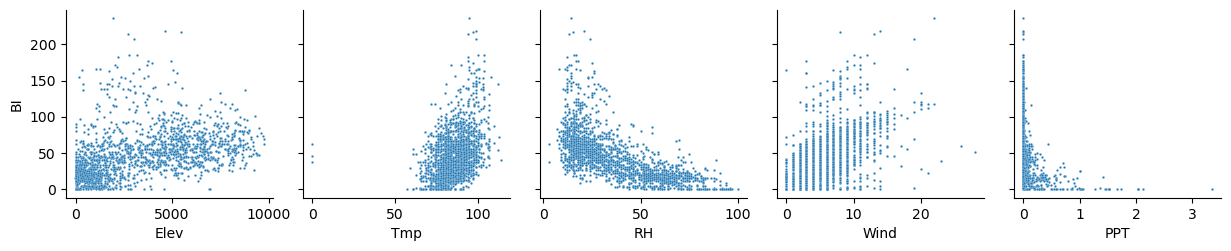

In [10]:
import seaborn as sns

sns.pairplot(wildfire_df_xu,
            x_vars=["Elev", "Tmp", "RH","Wind","PPT"],
            y_vars=['BI'],plot_kws={"s": 3})

Pre-processing - Normalize inputs to -1 - 1

In [11]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler(feature_range=(-0.99, 0.99),copy=True, clip=False)

for s in ["Elev", "Tmp", "RH","Wind","PPT"]:
    scaler = MinMaxScaler(feature_range=(-1, 1),copy=True, clip=False)
    transformed_values = scaler.fit_transform(np.expand_dims(wildfire_df_xu[s].values,1)).reshape(-1)
    
    wildfire_df_xu[s+'_standard'] = transformed_values
    
scaler = StandardScaler(copy=True)
bi_transformed_values = scaler.fit_transform(np.expand_dims(wildfire_df_xu['BI'].values,1)).reshape(-1)
wildfire_df_xu['BI_standard'] = bi_transformed_values

In [12]:
wildfire_df_xu = wildfire_df_xu[wildfire_df_xu['Tmp_standard']>-0.6]

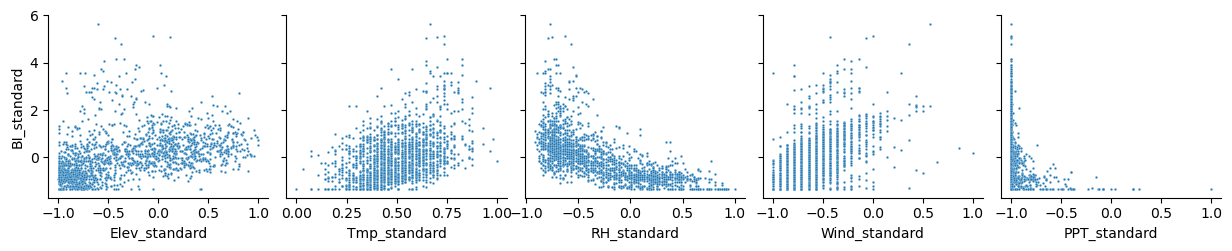

In [13]:
sns.pairplot(wildfire_df_xu,
            x_vars=["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard","PPT_standard"],
            y_vars=['BI_standard'],plot_kws={"s": 3})

Take a subet

Plot on Map

In [14]:
np.random.seed(0)

In [15]:
wildfire_df_xu_sub = wildfire_df_xu.sample(n=800)

## Fit Single QR Model First


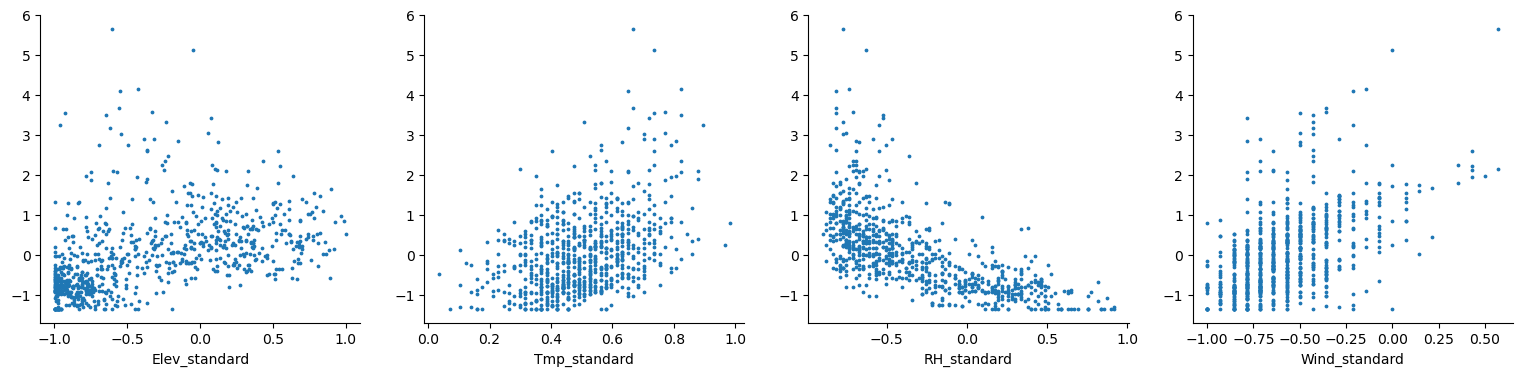

In [16]:
fig, ax = plt.subplots(1,4, figsize=(19,4))
for i,x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
    
    ax[i].scatter(wildfire_df_xu_sub[x_var_name],
                  wildfire_df_xu_sub['BI_standard'], s= 3)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_xlabel(x_var_name)

In [17]:
import arviz as az

Univariate Model
Track Block:  True
Step:  0  Time Taken:  0.6836190223693848
Step:  5000  Time Taken:  24.807824850082397
Step:  10000  Time Taken:  24.564471006393433
Step:  15000  Time Taken:  24.417355060577393


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/4021112523.py:152: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_cis = az.hdi(b0_samples.T[n_burn_in:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/4021112523.py:155: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_cis = az.hdi(b1_samples.T[n_burn_in:])


Univariate Model
Track Block:  True
Step:  0  Time Taken:  0.6971859931945801
Step:  5000  Time Taken:  24.990855932235718
Step:  10000  Time Taken:  24.439210891723633
Step:  15000  Time Taken:  24.59167194366455


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/4021112523.py:152: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_cis = az.hdi(b0_samples.T[n_burn_in:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/4021112523.py:155: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_cis = az.hdi(b1_samples.T[n_burn_in:])


Univariate Model
Track Block:  True
Step:  0  Time Taken:  0.8022680282592773
Step:  5000  Time Taken:  24.539170026779175
Step:  10000  Time Taken:  24.20600914955139
Step:  15000  Time Taken:  24.409340858459473


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/4021112523.py:152: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_cis = az.hdi(b0_samples.T[n_burn_in:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/4021112523.py:155: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_cis = az.hdi(b1_samples.T[n_burn_in:])


Univariate Model
Track Block:  True
Step:  0  Time Taken:  0.6902620792388916
Step:  5000  Time Taken:  24.872434854507446
Step:  10000  Time Taken:  24.108484745025635
Step:  15000  Time Taken:  23.74803900718689


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/4021112523.py:152: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_cis = az.hdi(b0_samples.T[n_burn_in:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/4021112523.py:155: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_cis = az.hdi(b1_samples.T[n_burn_in:])


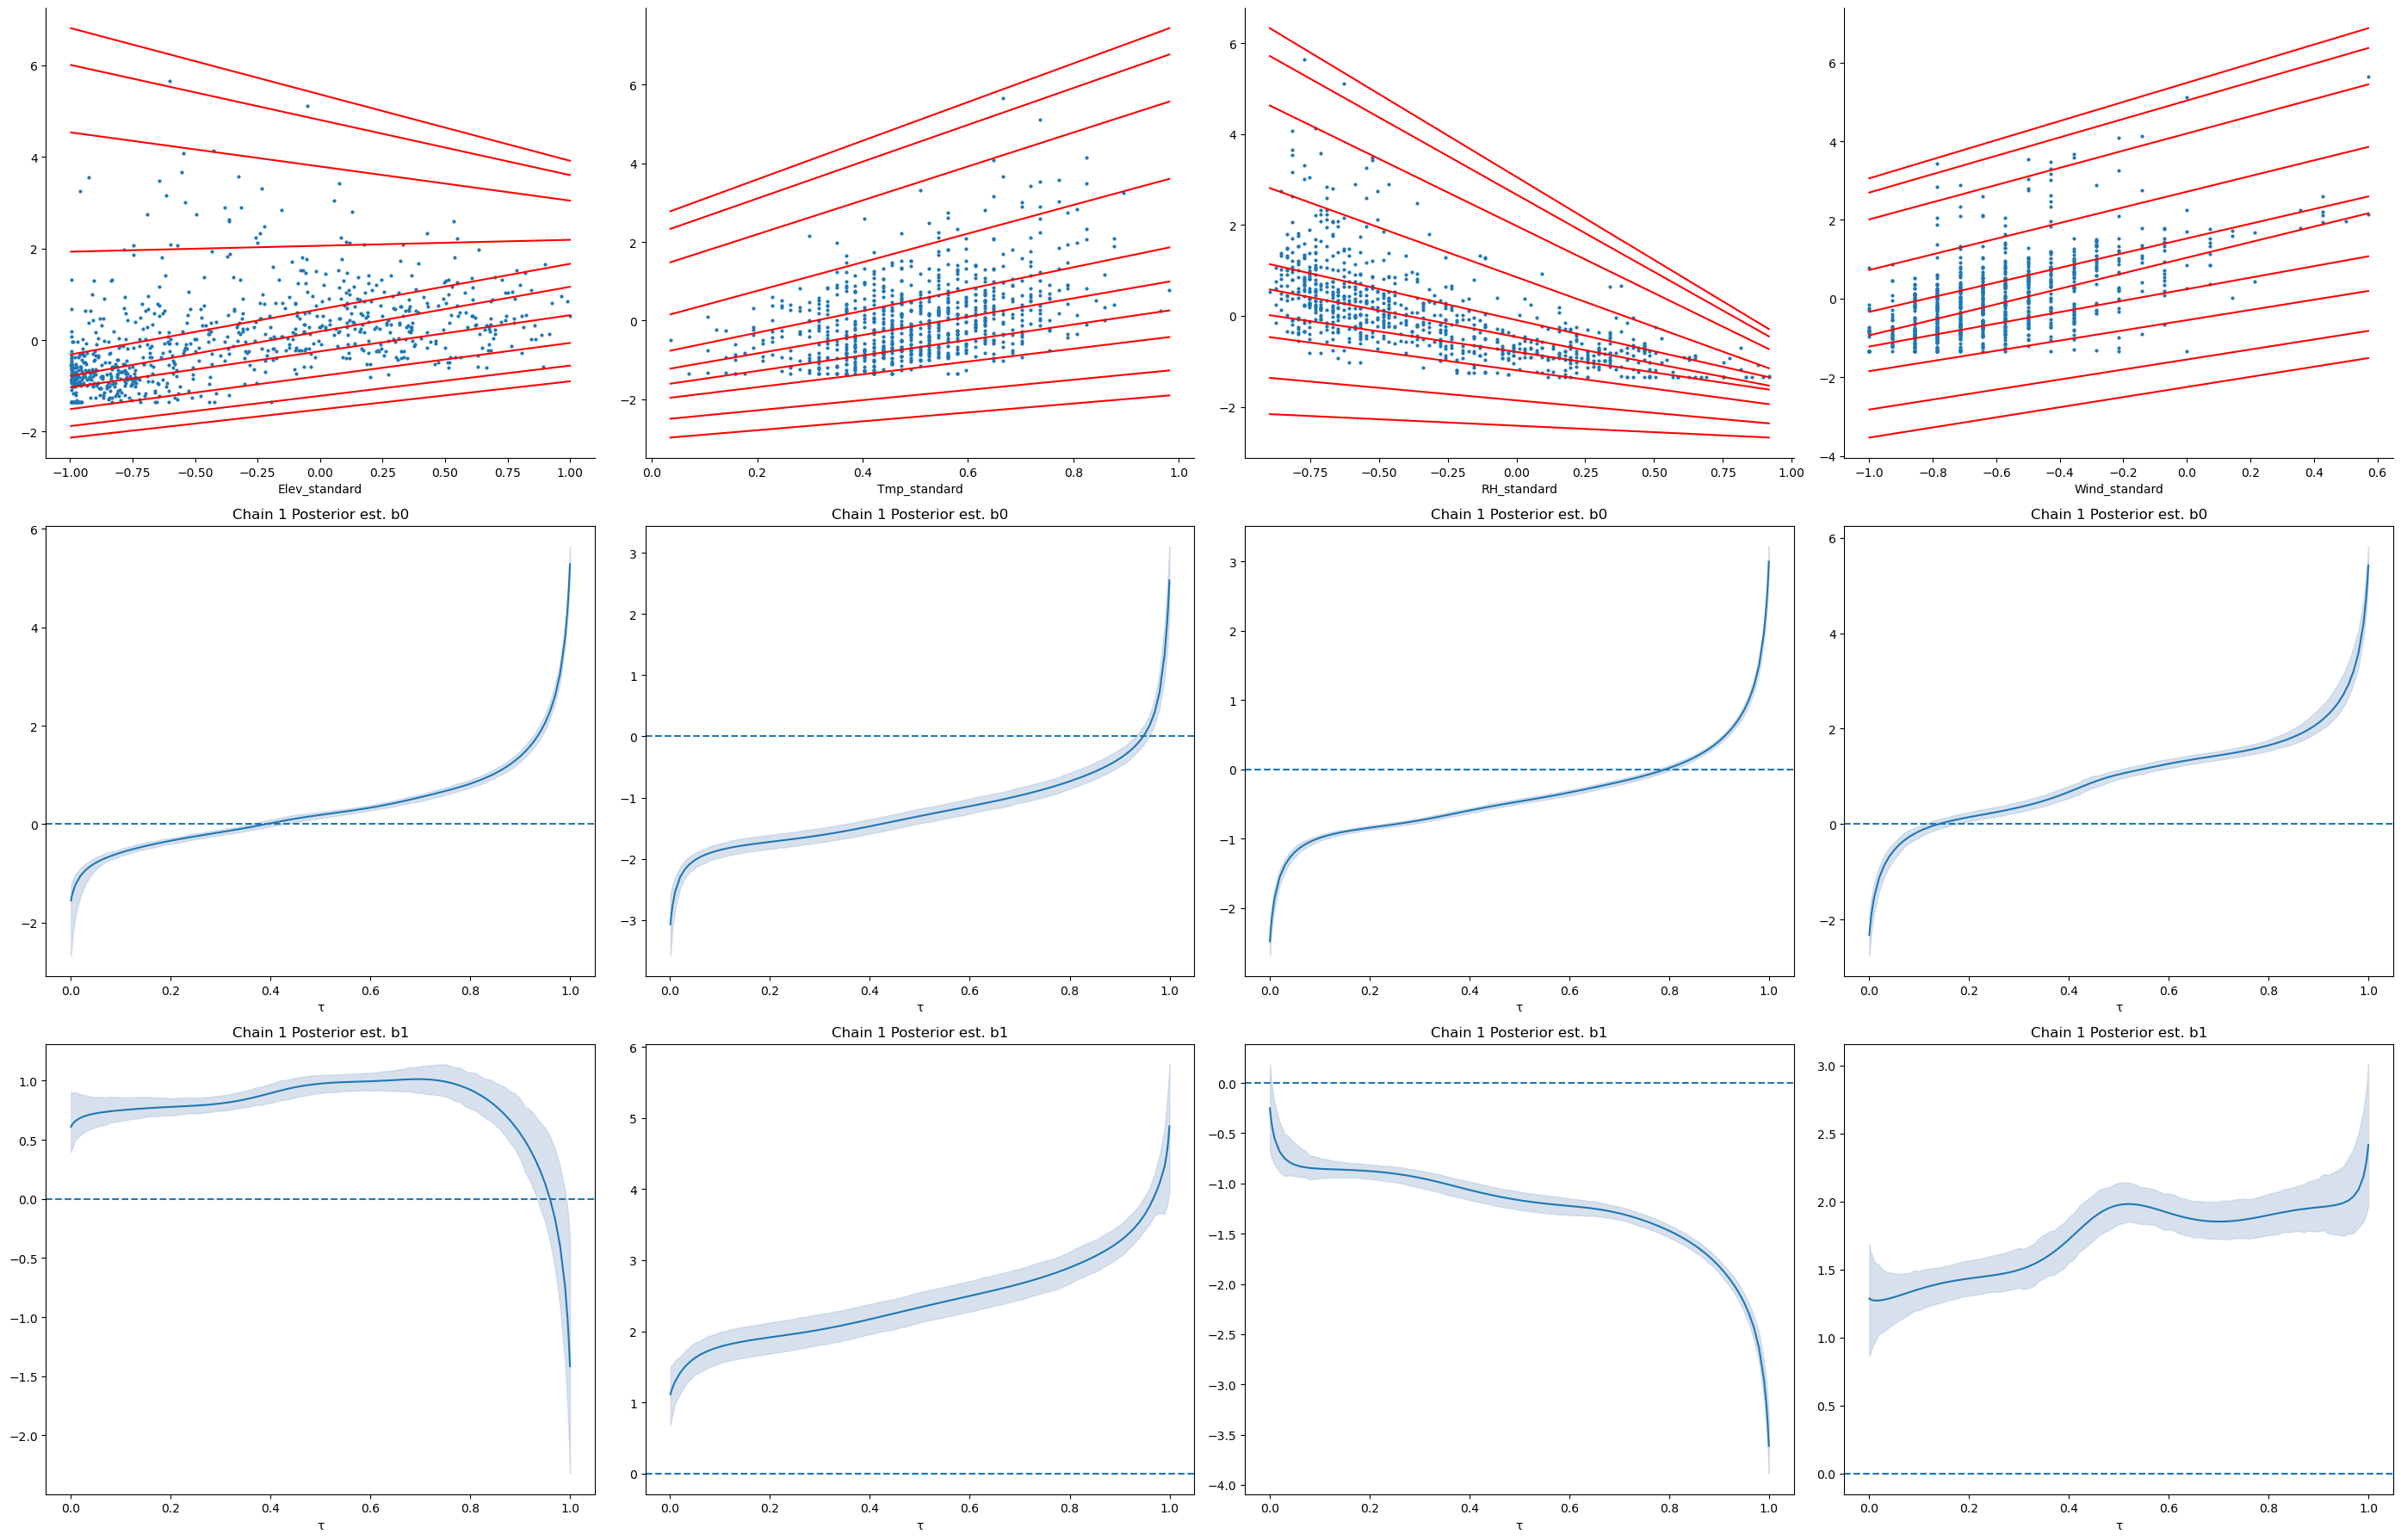

In [21]:
from Single_Var_QR import SingleQRSampler_T_4_block

np.random.seed(1234)

fig, ax = plt.subplots(3,4, figsize=(28,18))

chain_output_collate = {}
sampler_collector_collate = {}
posterior_plot = {}

for ax_id, x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):

    
    x_var = wildfire_df_xu_sub[x_var_name].values
    y_var = wildfire_df_xu_sub['BI_standard'].values
    
    
    quantile_dist = 't'
    prior_on_t = True

    # Choose no. of chains
    n_chains = 1
    n_steps = 20000
    n_burn_in = 5000

    # Set Grid of tau values
    tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
    tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
    knot_points_grid = np.arange(0.1,1,0.1)

    data_size = len(x_var)
    tau_upper_tail = 1-1/(2*data_size)
    tau_lower_tail = 1/(2*data_size)
    lower_seq = np.flip(geometric_seq(0.01, tau_lower_tail, 0.005, upper=False))
    upper_seq = geometric_seq(0.99, tau_upper_tail, 0.005)

    tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
    tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

    tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                        tau_grid,
                                        np.array([1,1.01])])

    # Run Sampler
    sampler_collecter_4blockt = [SingleQRSampler_T_4_block(y_var,
                                        x_var,          
                                        C_1 = 0.3,
                                        lambda_step_size_1 = 3,
                                        alpha_step_size_1 = 0.4,
                                        a_target_1 = 0.228,
                                        C_2 = 0.3,
                                        lambda_step_size_2 = 3,
                                        alpha_step_size_2 = 0.4,
                                        a_target_2 = 0.228,
                                        C_3 = 0.5,
                                        lambda_step_size_3 = 3,
                                        alpha_step_size_3 = 0.4,
                                        a_target_3 = 0.228,
                                        C_4 = 0.3,
                                        lambda_step_size_4 = 3,
                                        alpha_step_size_4 = 0.4,
                                        a_target_4 = 0.228,
                                        tau_grid_expanded = tau_grid_expanded,
                                        tau_grid = tau_grid,     
                                        knot_points_grid = knot_points_grid,
                                        am_lamb_block1_init = (2.38**2)/(9),
                                        am_lamb_block2_init = (2.38**2)/(9),
                                        am_lamb_block3_init = (2.38**2)/4,
                                        am_lamb_block4_init = (2.38**2)/(9*2+4),
                                        alpha_kappa = 0.1,
                                        beta_kappa = 0.1,
                                        eps_1 = 0,
                                        eps_2 = 0,
                                        base_quantile_mean=0.0,
                                        base_quantile_sd=1.0,
                                        base_quantile_v=1.0,
                                        base_quantile_dist=quantile_dist,
                                        prior_on_t=prior_on_t,
                                        splice=True,
                                        track_block=True) for _ in range(n_chains)]

    chain_outputs = [sampler_c.sample(n_steps=n_steps) for sampler_c in sampler_collecter_4blockt]

    sampler_collecter = sampler_collecter_4blockt
    
    chain_output_collate[x_var_name] = chain_outputs
    sampler_collector_collate[x_var_name] = sampler_collecter_4blockt[0]
    
    # Get sample quantile lines
    sample_quantiles = [0.01,0.05, 0.25, 0.5, 0.75, 0.95,0.99]
    sample_quantiles = [0.00125,0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99,0.9975,1]
    #sample_quantiles = [0.5]
    quantile_plot_store = []
    for sq in sample_quantiles:
        for i in range(n_chains):
            beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                          tau_grid=tau_grid_expanded,
                                                          w_approx_store=chain_outputs[i]['w'],
                                                          mu_store=chain_outputs[i]['mu'],
                                                          gamma_store=chain_outputs[i]['gamma'],
                                                          sigma_1_store=chain_outputs[i]['sigma_1'],
                                                          sigma_2_store=chain_outputs[i]['sigma_2'],
                                                          base_quantile_dist=quantile_dist,
                                                              v_store=chain_outputs[i]['v'])
            x_var_sorted = np.sort(x_var)
            y_pred_samples = np.array([b0 + b1*x_var_sorted for b0,b1 in zip(beta_0_samps, beta_1_samps)])
            y_pred_samples = y_pred_samples[n_burn_in:]

            ax[0, ax_id].plot(x_var_sorted, y_pred_samples.mean(0), color='red')
        quantile_plot_store.append((x_var_sorted, y_pred_samples.mean(0)))
        
    posterior_plot[x_var_name] = (sample_quantiles, quantile_plot_store)
            
    # Plot
    ax[0, ax_id].scatter(wildfire_df_xu_sub[x_var_name],wildfire_df_xu_sub['BI_standard'], s= 4)
    ax[0, ax_id].spines[['right', 'top']].set_visible(False)
    ax[0, ax_id].set_xlabel(x_var_name)
    
    
    # Get beta values
    chain_store = []
    for i in range(n_chains):
        b0_val_samples = []
        b1_val_samples = []
        for sq in tau_grid:
            beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                          tau_grid=tau_grid_expanded,
                                                          w_approx_store=chain_outputs[i]['w'],
                                                          mu_store=chain_outputs[i]['mu'],
                                                          gamma_store=chain_outputs[i]['gamma'],
                                                          sigma_1_store=chain_outputs[i]['sigma_1'],
                                                          sigma_2_store=chain_outputs[i]['sigma_2'],
                                                          base_quantile_dist=quantile_dist,
                                                              v_store=chain_outputs[i]['v'])

            b0_val_samples.append(beta_0_samps)
            b1_val_samples.append(beta_1_samps)

        b0_val_samples = np.array(b0_val_samples)
        b1_val_samples = np.array(b1_val_samples)

        chain_store.append([b0_val_samples, b1_val_samples])
        
    # Plot beta values

    for c in range(n_chains):

        b0_samples, b1_samples = chain_store[c]

        # Get b0 b1 means and CIs
        b0_mean = b0_samples.T[n_burn_in:].mean(0)
        b0_cis = az.hdi(b0_samples.T[n_burn_in:])

        b1_mean = b1_samples.T[n_burn_in:].mean(0)
        b1_cis = az.hdi(b1_samples.T[n_burn_in:])


        # Plot values
        # Beta 0
        ax[1,ax_id].plot(tau_grid, b0_mean, color='tab:blue')
        ax[1,ax_id].fill_between(tau_grid, b0_cis[:,0],
                        b0_cis[:,1], color='lightsteelblue', alpha=.5)
        
        # Beta 1
        ax[2,ax_id].plot(tau_grid, b1_mean, color='tab:blue')
        ax[2,ax_id].fill_between(tau_grid, b1_cis[:,0],
                        b1_cis[:,1], color='lightsteelblue', alpha=.5)

        ax[1,ax_id].title.set_text(f"Chain {c+1} Posterior est. b0")
        ax[2,ax_id].title.set_text(f"Chain {c+1} Posterior est. b1")

        ax[1,ax_id].set_xlabel('τ')
        ax[2,ax_id].set_xlabel('τ')
        
        ax[1, ax_id].axhline(y=0,linestyle='--')
        ax[2, ax_id].axhline(y=0,linestyle='--')

plt.tight_layout()

In [22]:
np.random.seed(1)

Fit Joint QR Models

In [23]:
from epa import *

In [24]:
from geopy.distance import geodesic

def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

In [25]:
wildfire_df_xu_sub['Long_adj'] = -1*np.abs(wildfire_df_xu_sub['Long'])

In [ ]:
wildfire_df_xu_sub.head()

In [192]:
# Set x var
x_var = wildfire_df_xu_sub['Wind_standard'].values
y_var = wildfire_df_xu_sub['BI_standard'].values

z_lat = wildfire_df_xu_sub['Lat'].values
z_lon = wildfire_df_xu_sub['Long_adj'].values
z_lon_alt = wildfire_df_xu_sub['Long'].values
num_points = len(z_lat)
distance_matrix = np.zeros((num_points, num_points))
distance_matrix_alt = np.zeros((num_points, num_points))

for i in range(num_points):
    for j in range(num_points):
        distance_matrix[i, j] = haversine(z_lat[i], z_lon[i], z_lat[j], z_lon[j])
        distance_matrix_alt[i, j] = haversine(z_lat[i], z_lon_alt[i], z_lat[j], z_lon_alt[j])


In [193]:
# Convert to similarity matrix
d_norm = distance_matrix/np.max(distance_matrix)
sim_mat = 1-d_norm + 0.01

d_norm_alt = distance_matrix_alt/np.max(distance_matrix_alt)
sim_mat_alt = 1-d_norm_alt + 0.01

Do Agglo Clustering on Distance Matrix First

In [194]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering = AgglomerativeClustering(n_clusters=3, linkage='average')
agglo_pre_clusters = clustering.fit_predict(sim_mat)

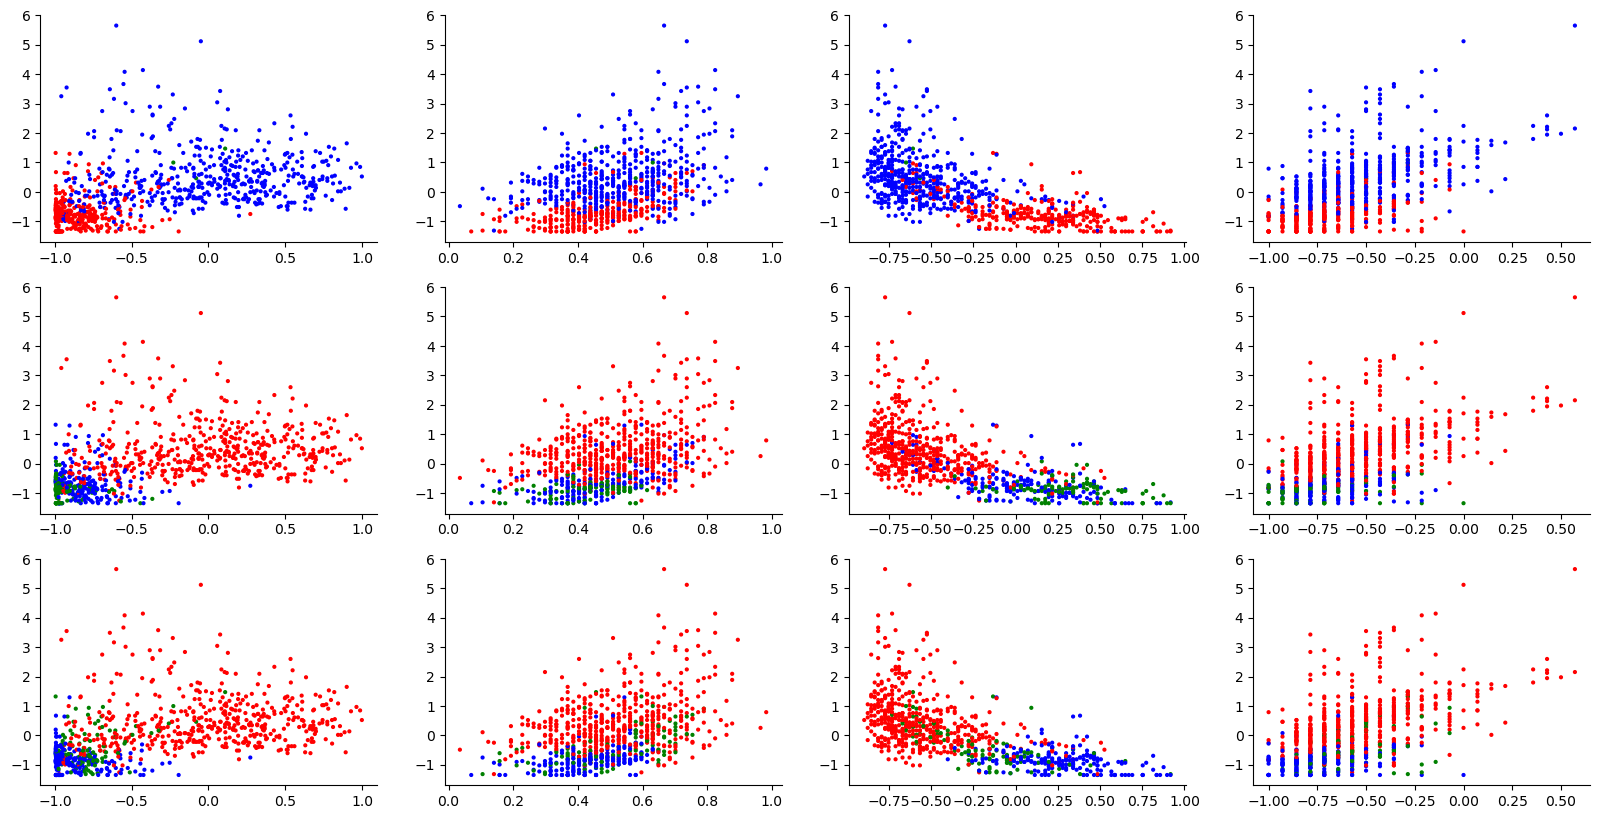

In [195]:
fig,ax = plt.subplots(3,4,figsize=(20,10))
agglo_cols = ['red','blue','green']

for ax_id_row, c_type in enumerate(['single','complete','average']):
    
    clustering = AgglomerativeClustering(n_clusters=3, linkage=c_type)
    agglo_pre_clusters = clustering.fit_predict(sim_mat)

    for ax_id_col, x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]): 
    
        ax[ax_id_row, ax_id_col].scatter(x=wildfire_df_xu_sub[x_var_name],
                   y=wildfire_df_xu_sub['BI_standard'], s=4,
                  color=[agglo_cols[i] for i in agglo_pre_clusters])
        
        ax[ax_id_row, ax_id_col].spines[['right', 'top']].set_visible(False)


In [196]:
wildfire_df_xu_sub['Long_adj'] = -1*np.abs(wildfire_df_xu_sub['Long'])

In [197]:
import plotly.express as px

clustering = AgglomerativeClustering(n_clusters=3, linkage='average')
agglo_pre_clusters = clustering.fit_predict(sim_mat)
wildfire_df_xu_sub['Agglo_clusters'] = agglo_pre_clusters


# Assuming wildfire_data_df_xu is your DataFrame
fig = px.scatter_geo(wildfire_df_xu_sub, lat='Lat', lon='Long_adj', color='Agglo_clusters',
                     hover_data=wildfire_df_xu_sub.columns, scope='usa')

fig.update_geos(showcountries=True, countrycolor="Black", showsubunits=True, subunitcolor="Black")

fig.update_layout(title='Wildfire Data Map of the USA with State Boundaries',
                  geo=dict(showland=True, landcolor="lightgray"))

fig.show()


In [198]:
c1_params = chain_output_collate['Wind_standard'][0]

In [199]:
Ys = y_var
Xs = x_var

In [200]:
np.random.seed(2024)

In [201]:
start_time = time.time()

lambda_init = 'tight' # 'standard'/'tight'

# similarity mat
tau = 2
#lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)
lambda_matrix = sim_mat

# Calc lambda

# intialize 
names_used = np.array([1,2])
alpha_samp = 1

# try with good distance function
partition_samp = np.array([1 if x<= 0 else 2 for x in Xs])  # Set initialization for lambda
#partition_samp = inds_train.copy()



# Scramble initialization after
partition_samp = np.array([1 if np.random.uniform(0,1)<0.5 else 2 for x in Xs])  # try no initialization
partition_init  = partition_samp.astype('int')

delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(len(Ys))
np.random.shuffle(order_samp)


#### gibbs sampling hyper parameters
n_gibbs = 2000
n_burn_in = 1000
k = 400 # no. of numbers to permute order
n_chain = 2

# GRW sampler param
rw_sd = 0.2

# alpha prior -> Want alpha to be small,  gammma prior so mean = a/b
alpha_init = 0.005
a_alpha = 1
b_alpha = 200
alpha_bounds = [0,1e99]

# delta prior -> Want delta to be smal lalso gammma prior so mean = a/b
a_delta = 1
b_delta = 100
w_delta = 0.5
delta_bounds = [0,1]
delta_init = 0

# Tau prior
sample_tau = False
tau_bounds = [0,99]
a_tau = 4
b_tau = 2
tau_init = 1

labels_used = np.array([1,2])

reordering = True
use_split_merge_step = False


# phi sample - w1, w2, mu,gamma,sigma1,sigma2 - store as a vector

##############################
#### initialize QR Params ####
##############################
splice = True
m = 9

if not prior_on_t:
    phi_init = np.zeros([len(labels_used),
                    m+m+4])
else:
    phi_init = np.zeros([len(labels_used),
                    m+m+5])


# Set tau grid
#tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
#tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
knot_points_grid = np.arange(0.1,1,0.1)
m = len(knot_points_grid)

eta1_init = np.zeros([len(labels_used),
                     len(tau_grid)])
eta2_init = np.zeros([len(labels_used),
                     len(tau_grid)])
    
# Get lambda PDF
h=0.1
lambd_collect = calc_lambd_grid_uncorr(knot_points_grid.reshape(-1,1),
                                    h=h,
                                    rho_lambd_init=0.99)
lambd_grid = np.array(lambd_collect)
grid_pdf_vals = lamb_pdf(lambd_grid)
lambda_grid_log_prob = np.log(grid_pdf_vals)

#### Initialize Model Parameters
## GP Related hyperparameters
kappa_current = np.nan
rho_current = 0.1
lambd_current = 4
alpha_kappa = 3
beta_kappa = 1/3

## Regression related parametrs
mu_current = 0
gamma_current = 0
sigma_1_current = 1
sigma_2_current = 1


#### W samples 
# calc covariance matrix
cov_mat_knots_current = covariance_matrix_gp_uncorr(knot_points_grid.reshape(-1,1),
                                  lambd=lambd_current)
# Precompute Matrices
cov_matrices_G, A_matrices_G = precompute_approx_uncorr(tau_grid_expanded.reshape(-1,1),
                                                   knot_points_grid.reshape(-1,1),
                                                   lambda_grid=lambd_grid)

for j in range(len(labels_used)):
    
    # Initialise w1, w2 knots 
    w1_knot_points_current_j = np.array(c1_params['w1_knot'][n_steps-200:n_steps-1]).mean(0)

    w2_knot_points_current_j = np.array(c1_params['w2_knot'][n_steps-200:n_steps-1]).mean(0)

    
    remain_params_j = np.array([np.array(c1_params['mu'][n_steps-200:n_steps-1]).mean(0),
                                np.array(c1_params['gamma'][n_steps-200:n_steps-1]).mean(0),
                                np.array(c1_params['sigma_1'][n_steps-200:n_steps-1]).mean(0),
                                np.array(c1_params['sigma_2'][n_steps-200:n_steps-1]).mean(0)])


    if prior_on_t:
        v_hat = np.array(c1_params['v'][n_steps-200:n_steps-1]).mean()
    else:
        v_hat=1.0
    
            
    if prior_on_t:
    # Store into phi_j
        phi_j = np.concatenate([w1_knot_points_current_j,
                                w2_knot_points_current_j,
                                remain_params_j, np.array([v_hat])])
    else:
        phi_j = np.concatenate([w1_knot_points_current_j,
                            w2_knot_points_current_j,
                            remain_params_j])

    phi_init[j] = phi_j
    
    #### Get associated Quantile Function for each phi_j ####
    w1_knot_prop = w1_knot_points_current_j
    w2_knot_prop = w2_knot_points_current_j
    # Get approx
    w1_approx_prop_j, lp_w1_j = calc_mixture_knot_approx_marginalized(w1_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    
    w2_approx_prop_j, lp_w2_j = calc_mixture_knot_approx_marginalized(w2_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    # Get Q function
    mu_j, gamma_j, sigma1_j, sigma2_j = phi_j[18],phi_j[19],phi_j[20],phi_j[21]

    # get Eta functions
    eta_1_j  = eta_function_i_vector(tau_input=tau_grid,
                               w_vals=w1_approx_prop_j,
                               tau_grid=tau_grid_expanded,
                               mean=0.0,
                               sd=1.0,
                               v=v_hat,
                               sigma=sigma1_j,
                               dist=quantile_dist)

    eta_2_j  = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w2_approx_prop_j,
                           tau_grid=tau_grid_expanded,
                           mean=0.0,
                           sd=1.0,
                           v=v_hat,
                           sigma=sigma2_j,
                           dist=quantile_dist)

    eta1_init[j] = eta_1_j
    eta2_init[j] = eta_2_j

In [202]:
Ys = y_var
Xs = x_var
Zs = None
sim_mat = sim_mat
partition_init = partition_init
phi_init = phi_init

tau_init =   tau_init
labels_used = labels_used
alpha_init = alpha_init
delta_init = delta_init
n_gibbs = n_gibbs
n_burn_in = n_burn_in
k = k
a_alpha = a_alpha
b_alpha = b_alpha
a_delta = a_delta
b_delta = b_delta
a_tau =  a_tau
b_tau =  b_tau
w_delta = 0.5
reordering = reordering
use_split_merge_step = use_split_merge_step
sample_tau = False

In [203]:
n = len(Ys)
# intialize 
names_used = labels_used
alpha_samp = alpha_init

delta_samp = delta_init
order_samp = np.arange(n)
np.random.shuffle(order_samp)

# initialize QR params
phi_samp = phi_init
eta1_samp = eta1_init
eta2_samp = eta2_init

partition_samp = partition_init
tau_samp = tau_init


#### gibbs sampling hyper parameters
n_gibbs = n_gibbs
k = k # no. of numbers to permute order

# GRW sampler param
rw_sd = 0.2

# alpha prior
a_alpha = a_alpha
b_alpha = b_alpha
alpha_bounds = [0,1e99]

# delta prior
a_delta = a_delta
b_delta = b_delta

assert (w_delta<=1) and (w_delta>=0)
w_delta = w_delta
delta_bounds = [0,1]
tau_bounds = [0,1e99]


partition_save = []
alpha_save = []
delta_save = []
phi_save = []
log_prob_save = []
sigma_reg_save = []
tau_save = []

# Track acceptance rates
split_merge_accept_save = []
tau_accept_save = []
delta_accept_save = []
order_accept_save = []
alpha_accept_save = []


s1 = time.time()
# Gibbs loop
for g in range(n_gibbs+n_burn_in):
    if g%100 == 0:
        e1 = time.time()
        print("Gibbs: ", g, " Time Taken: ", (e1-s1)/60)
        print("Active No Clusters: ", len(np.unique(partition_samp)))
        print("Active No Clusters: ", pd.Series(partition_samp).value_counts())
        s1 = time.time()

    # Get last term in order samp
    #last_term_samp = order_samp[-1]
    last_term_id = order_samp[-1]#np.where(order_samp == np.max(order_samp))[0][0]

    #print('Partition Update')
    # Draw sample for the final term
    if prior_on_t:
        v_samp = phi_samp[-1]
    else:
        v_samp = 1.0
    
    partition_samp, phi_samp, names_used, \
        partition_factors, eta1_samp, eta2_samp = sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                    i=last_term_id,
                                    order_place=0,
                                    partition=partition_samp,
                                    return_fac=True,
                                    pre_compute_factors=np.zeros(1),
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    sim_mat=sim_mat,
                                    order=order_samp,
                                    phi=phi_samp,
                                    eta1_mat=eta1_samp, 
                                    eta2_mat=eta2_samp,
                                    y=Ys,
                                    x=Xs,
                                    A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                       w_cov_mat=cov_mat_knots_current,
                                      alpha_kappa=5,
                                      beta_kappa=1/3,
                                      tau_grid=tau_grid,
                                      tau_grid_expanded=tau_grid_expanded,
                                    base_quantile_mean=0.0,
                                     base_quantile_sd=1.0,
                                     base_quantile_v=v_samp,
                                     base_quantile_dist=quantile_dist,
                                    names_used=names_used,                      
                                    reordering=reordering,
                                    splice=splice,
                                    prior_on_t=prior_on_t)
    
    for o in list(range(len(order_samp)-2,-1,-1)):

        term_id = order_samp[o]#np.where(order_samp == o)[0][0]

        partition_samp, phi_samp, names_used,\
              eta1_samp, eta2_samp= sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                        i=term_id,
                                        order_place=o,
                                        partition=partition_samp,
                                        return_fac=False,
                                        pre_compute_factors=partition_factors,
                                        alpha=alpha_samp,
                                        delta=delta_samp,
                                        sim_mat=sim_mat,
                                        order=order_samp,
                                        phi=phi_samp,
                                        eta1_mat=eta1_samp, 
                                        eta2_mat=eta2_samp,
                                        y=Ys,
                                        x=Xs,
                                        A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                    
                                           w_cov_mat=cov_mat_knots_current,
                                          alpha_kappa=5,
                                          beta_kappa=1/3,
                                          tau_grid=tau_grid,
                                          tau_grid_expanded=tau_grid_expanded,
                                        base_quantile_mean=0.0,
                                         base_quantile_sd=1.0,
                                         base_quantile_v=v_samp,
                                         base_quantile_dist=quantile_dist,
                                        names_used=names_used,
                                        reordering=reordering,
                                            prior_on_t=prior_on_t)

    """
    if use_split_merge_step:
    #### Split Merge step ####
        partition_samp,phi_samp, names_used,\
        sigma2_reg_samp, accept_samp = split_merge_step(partition_samp=partition_samp,
                                                    alpha=alpha_samp,
                                                    delta=delta_samp,
                                                    sim_mat=sim_mat,
                                                    order=order_samp,
                                                    phi_samp=phi_samp,
                                                    y=Ys,
                                                    x=Xs, 
                                                    sigma2_reg_samp=sigma2_reg_samp,
                                                    v_0=v_0,
                                                    sigma2_0=sigma2_0,
                                                    names_used=names_used, 
                                                    phi_base_mean=phi_mean_prior,
                                                    phi_base_cov=phi_cov_prior,
                                                    no_intermediate_steps=5)

        if g>n_burn_in:

            split_merge_accept_save.append(accept_samp)
    """

    partition_samp = partition_samp.astype('int')

    
    #print("Sampling Phi")
    phi_samp, eta1_samp, eta2_samp = sample_phi_QR(phi_cur=phi_samp,
                           eta1_cur=eta1_samp,
                           eta2_cur=eta2_samp,
                           n_steps=200,
                           y=Ys,
                           x=Xs,
                            A_matrices_G = A_matrices_G,
                        cov_matrices_G = cov_matrices_G,
                        lambda_grid_log_prob= lambda_grid_log_prob,
                        cov_mat_knots_init=cov_mat_knots_current,
                           partition=partition_samp,
                          tau_grid=tau_grid,
                           tau_grid_expanded=tau_grid_expanded,
                           base_quantile_mean=0.0,
                           base_quantile_sd=1.0,
                           base_quantile_v=1.0,
                          base_quantile_dist=quantile_dist,
                          prior_on_t=prior_on_t)

    # Sample ordering 
    #order_samp = permute_k(order_samp, k)
    #print("Sample Order")
    order_samp,order_accept_s = metropolis_step_order(order_current=order_samp,
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    partition=partition_samp,
                                    sim_mat=sim_mat,
                                    k=k)

    if g>n_burn_in:
        order_accept_save.append(order_accept_s)

    #### Sample parameters, alpha, sigma
    #print("Sampling Alpha")
    alpha_samp, alpha_accept_s = metropolis_step_alpha(alpha_samp,
                                                    rw_sd,
                                                    a_alpha, b_alpha,
                                                    partition_samp,
                                                        delta_samp,
                                                        sim_mat,
                                                        order_samp,
                                                    bounds=alpha_bounds)

    if g>n_burn_in:
        alpha_accept_save.append(alpha_accept_s)

    #print("Sampling Delta")
    delta_samp, delta_accept_s = metropolis_step_delta(delta_samp, rw_sd,
                                                    a_delta, b_delta, w_delta,
                                                    partition_samp,
                                                        alpha_samp,
                                                        sim_mat,
                                                        order_samp,bounds=delta_bounds)

    if g>n_burn_in:
        delta_accept_save.append(delta_accept_s)

    # Update Tau + Sim mat
    if sample_tau:
        tau_samp, sim_mat, tau_accept_s = metropolis_step_tau(tau_samp, rw_sd, a_tau, b_tau,
                            partition_samp,
                                alpha_samp,
                                delta_samp,
                                sim_mat,
                                X=Zs.reshape(-1,1),
                        order=order_samp,bounds=tau_bounds)

        if g>n_burn_in:
            tau_accept_save.append(tau_accept_s)

    """
    # Calc log prob of result
    log_prob_samp = calc_log_joint(partition=partition_samp,
                                phi=phi_samp,
                                y=Ys,
                                x=Xs,
                                sim_mat=sim_mat,
                                order=order_samp,
                                alpha=alpha_samp,
                                delta=delta_samp,
                                sigma_reg = sigma_reg)
    """

    if g>n_burn_in:

        # Save sampled values
        #log_prob_save.append(log_prob_samp)
        partition_save.append(partition_samp)
        alpha_save.append(alpha_samp)
        delta_save.append(delta_samp)
        phi_save.append(phi_samp)
        tau_save.append(tau_samp)


acceptance_rates = {'Split Merge': np.mean(split_merge_accept_save),
                    'Tau': np.mean(tau_accept_save),
                    'Delta': np.mean(delta_accept_save),
                    'Order': np.mean(order_accept_save),
                    'Alpha': np.mean(alpha_accept_save)}

acceptance_rates = pd.DataFrame.from_dict(acceptance_rates, orient='index')
acceptance_rates.columns=['Acceptance Rate']
acceptance_rates


Gibbs:  0  Time Taken:  7.617473602294922e-06
Active No Clusters:  2
Active No Clusters:  2    403
1    397
Name: count, dtype: int64
Gibbs:  100  Time Taken:  9.499510669708252
Active No Clusters:  3
Active No Clusters:  1    508
2    256
3     36
Name: count, dtype: int64
Gibbs:  200  Time Taken:  10.69182348648707
Active No Clusters:  3
Active No Clusters:  1    468
2    279
3     53
Name: count, dtype: int64
Gibbs:  300  Time Taken:  11.421451850732167
Active No Clusters:  3
Active No Clusters:  1    465
2    297
3     38
Name: count, dtype: int64
Gibbs:  400  Time Taken:  11.519548185666402
Active No Clusters:  3
Active No Clusters:  1    450
2    303
3     47
Name: count, dtype: int64
Gibbs:  500  Time Taken:  11.419646934668224
Active No Clusters:  3
Active No Clusters:  1    475
2    276
3     49
Name: count, dtype: int64
Gibbs:  600  Time Taken:  11.529594266414643
Active No Clusters:  3
Active No Clusters:  1    469
2    277
3     54
Name: count, dtype: int64
Gibbs:  700  Tim

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.



Acceptance Rate
Split Merge              NaN
Tau                      NaN
Delta               0.000000
Order               0.007004
Alpha               0.043522


Get clustering matrix

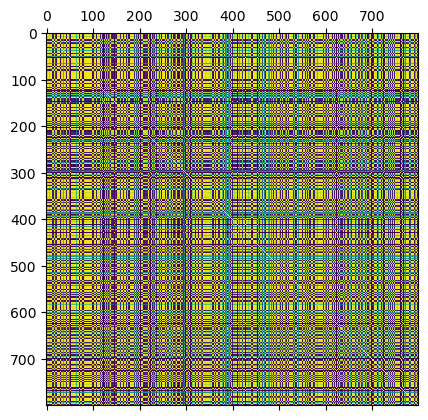

In [204]:
cluster_size_samples = np.array([len(np.unique(p)) for p in partition_save])
np.mean(cluster_size_samples)


normalized_sim_mat = calc_hit_matrix(partition_save,
                                     burn_samples=0,
                                     normalize=True)

plt.matshow(normalized_sim_mat)
plt.show()

In [205]:
np.mean(cluster_size_samples)


3.0275137568784394

/Users/tzehongti/miniforge3/envs/geopandas/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



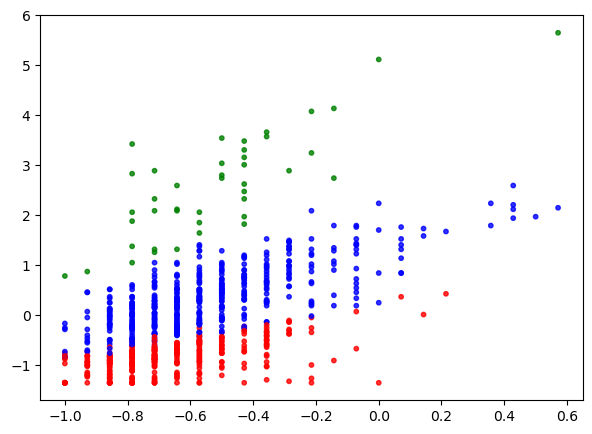

<Figure size 640x480 with 0 Axes>

In [220]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=3,
                                       linkage_type='complete')

fig, ax = plt.subplots(figsize=(7,5))


ax.scatter(Xs, Ys,
            s=10,
           color=[agglo_cols[i] for i in agglo_cluster_solution], alpha=0.8)



plt.show()
plt.savefig('Exp Results/Xu Dataset/Run 2/Wind/Clustering_plot.png')


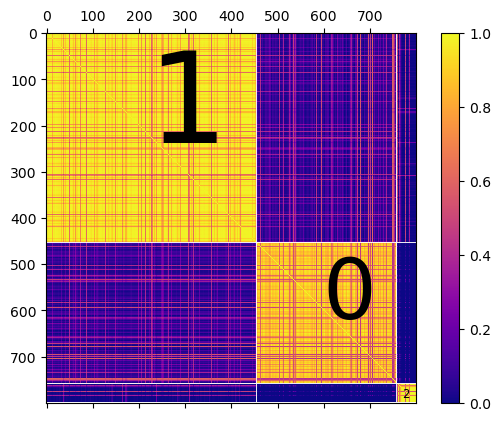

In [221]:
# Calculate c-vals
c_vals = calc_c_vals(agglo_cluster_solution, normalized_sim_mat)

sorted_clust_names = pd.Series(agglo_cluster_solution).value_counts().index

arranged_ids = []
for c in sorted_clust_names:

    clust_ids = np.where(agglo_cluster_solution==c)[0]
    c_vals_clust = c_vals[clust_ids]
    sorted_clust_ids =clust_ids[np.argsort(c_vals_clust)[::-1]]
    
    arranged_ids.append(sorted_clust_ids)
    
arranged_ids = np.concatenate(arranged_ids)

sorted_matrix = np.zeros((len(Ys),len(Ys)))

for i in range(len(Ys)):
    for j in range(len(Ys)):
        
        sorted_matrix[i,j] = normalized_sim_mat[arranged_ids[i], arranged_ids[j]]

figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(sorted_matrix, cmap='plasma')
figure.colorbar(caxes)

clust_sizes = pd.Series(agglo_cluster_solution).value_counts().values

for clust_size,clust_name, n in zip(clust_sizes,sorted_clust_names,clust_sizes.cumsum()):
    
    axes.axvline(n-1,c='white',lw=0.65)
    axes.axhline(n-1,c='white',lw=0.65)

    axes.text(n-clust_size//2-10, n-clust_size//2+10, str(clust_name), color="k", fontsize=clust_size/5)


plt.savefig('Exp Results/Xu Dataset/Run 2/Wind/mixture_QR_conf_plot.png')
plt.show()

Plot Clusters on Map

In [222]:
import kaleido

In [223]:
import plotly.express as px

wildfire_df_xu_sub['posterior_clusters'] = agglo_cluster_solution


# Assuming wildfire_data_df_xu is your DataFrame
fig = px.scatter_geo(wildfire_df_xu_sub, lat='Lat', lon='Long_adj', color='posterior_clusters',
                     hover_data=wildfire_df_xu_sub.columns, scope='usa')

fig.update_geos(showcountries=True, countrycolor="Black", showsubunits=True, subunitcolor="Black")

fig.update_layout(title='Wildfire Data Map of the USA with State Boundaries - Posterior Clusters',
                  geo=dict(showland=True, landcolor="lightgray"))

fig.show()
#fig.write_image("Exp Results/Xu Dataset/Run 1/Elev/posterior_cluster_map.png")

Get posterior samples

In [224]:
X_train = Xs
y_train = Ys

In [225]:
Q_sample_collect = []
x_vals_checker = []
omitted_samps = 0
omitted_samp_id = []
omitted_samp_out = []
#bad_samps1 = np.where(np.min(np.min(Q_sample_collect,1),1)<-30)[0]
#bad_samps2 = np.where(np.min(np.min(Q_sample_collect,1),1)>30)[0]


for i in range(n_gibbs-1):#range(n_gibbs-1): # range(n_gibbs-1):
    
    #if (i in bad_samps1) or (i in bad_samps2):
     #   continue
    
    # Get cluster
    partition_samp = partition_save[i]

    # Get phi samp
    phi_samp = phi_save[i]

    output_q_tx = []
    x_vals_arr = []
    # Iterate through each cluster
    for k in np.unique(partition_samp):

        # Extract data points + phi_k
        phi_k = phi_samp[k-1]

        point_ids = np.where(partition_samp==k)[0]

        # Extract X Values
        x_vals_k = X_train[point_ids]

        # Using phi generate the quantile regression function
        phi_samp_clust = phi_samp[k-1,:]
        m = (len(phi_samp_clust) - 4)// 2
        w1_knot_points_current = phi_samp_clust[0:m]
        w2_knot_points_current = phi_samp_clust[m:2*m]
        mu_current = phi_samp_clust[2*m]
        gamma_current = phi_samp_clust[2*m+1]
        #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
        #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
        sigma_1_current = phi_samp_clust[2*m+2]
        sigma_2_current = phi_samp_clust[2*m+3]
        
        if prior_on_t:
            v_current = phi_samp_clust[2*m+4]
        else:
            v_current = 1.0
        # Generate quantities
        
        # Generate sample of GP approx
        w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)

        w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)
        
        # Generate Q
        eta_1  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w1_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_1_current,
                            dist=quantile_dist)

        eta_2  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w2_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_2_current,
                            dist=quantile_dist)
        
        Q_tx  = mu_current + gamma_current * np.expand_dims(x_vals_k, -1) + \
            np.expand_dims((1-x_vals_k)/2, -1) * eta_1 + \
            np.expand_dims((1+x_vals_k)/2, -1) * eta_2
        
        beta_0_samp = mu_current + (eta_1 + eta_2)/2
        beta_1_samp = gamma_current + (eta_1 - eta_2)/2
        
        Q_tx_alt = np.array([b0 + b1*x_vals_k for b0,b1 in zip(beta_0_samp, beta_1_samp)])
        
        output_q_tx.append(Q_tx_alt.T)
        x_vals_arr.append(x_vals_k)

    output_q_tx = np.concatenate(output_q_tx,0)
    x_vals_arr = np.concatenate(x_vals_arr,0)
    
    sort_ids = np.argsort(x_vals_arr)
    x_vals_arr = x_vals_arr[sort_ids]
    output_q_tx = output_q_tx[sort_ids,:]
    
    # Optional
    if (np.max(output_q_tx) > 1e2) or (np.min(output_q_tx)<-1e2):
        omitted_samps += 1
        omitted_samp_id.append(i)
        omitted_samp_out.append(output_q_tx)
        continue
        
    Q_sample_collect.append(output_q_tx)
    x_vals_checker.append(x_vals_arr)

Q_sample_collect = [Q.reshape(1,len(X_train),len(tau_grid)) for Q in Q_sample_collect]
Q_sample_collect = np.concatenate(Q_sample_collect,0)

In [226]:
omitted_samp_id

[1059]

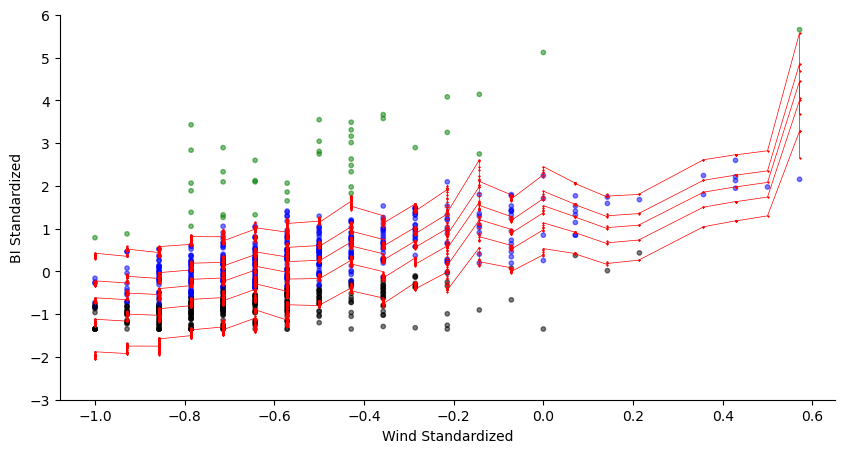

In [230]:
quantile_means = np.mean(Q_sample_collect,0)


# Extract some arrays
wanted_taus = [0.05, 0.25, 0.5, 0.75, 0.95]
tau_ids = np.array([np.where(tau_grid==w_t)[0][0] for w_t in wanted_taus])

plot_qtx = quantile_means[:, tau_ids]

fig, ax = plt.subplots(figsize=(10,5))

color_list =['black','blue','green']

ax.scatter(X_train, y_train,
            s=10, color=[color_list[i] for i in agglo_cluster_solution], alpha=0.5)

ax.plot(x_vals_arr, plot_qtx,alpha=1,lw=0.5, c='red',marker='*',ms=1)
ax.set_ylim([-3,6])
ax.set_xlabel('Wind Standardized')
ax.set_ylabel('BI Standardized')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('Exp Results/Xu Dataset/Run 2/Wind/mixture_QR_quantile_lines.png')
plt.show()

In [231]:
tau_ids

array([ 8, 28, 53, 78, 98])

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/2859023850.py:13: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/2859023850.py:13: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/2859023850.py:13: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/2859023850.py:13: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_

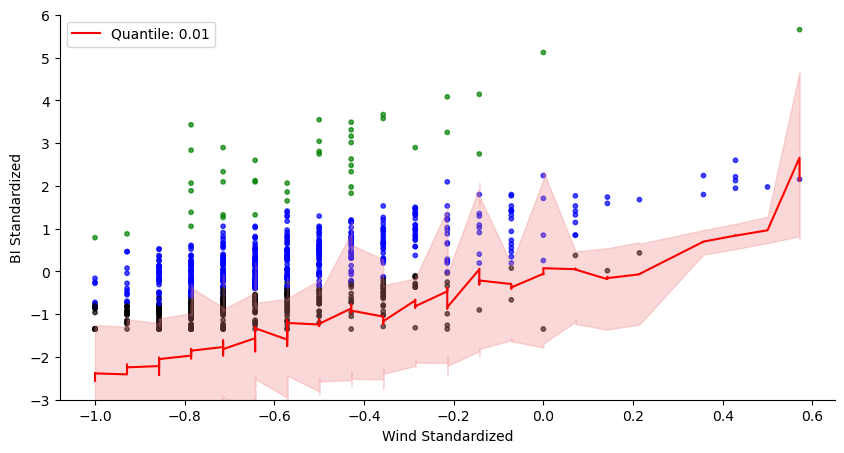

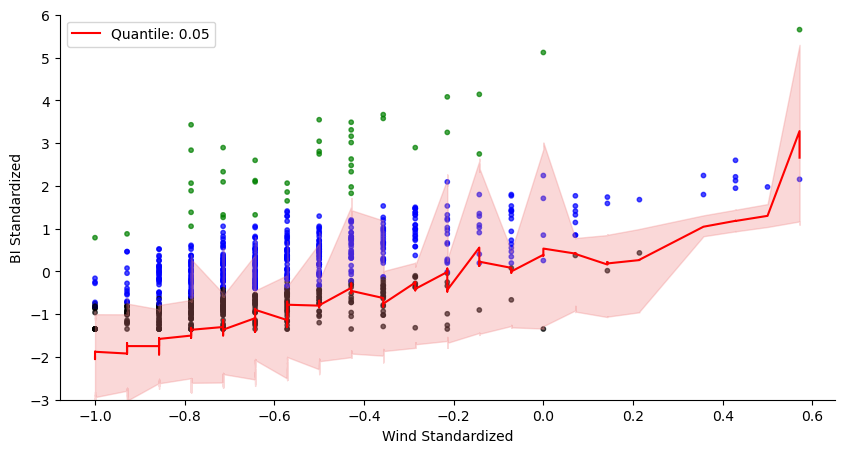

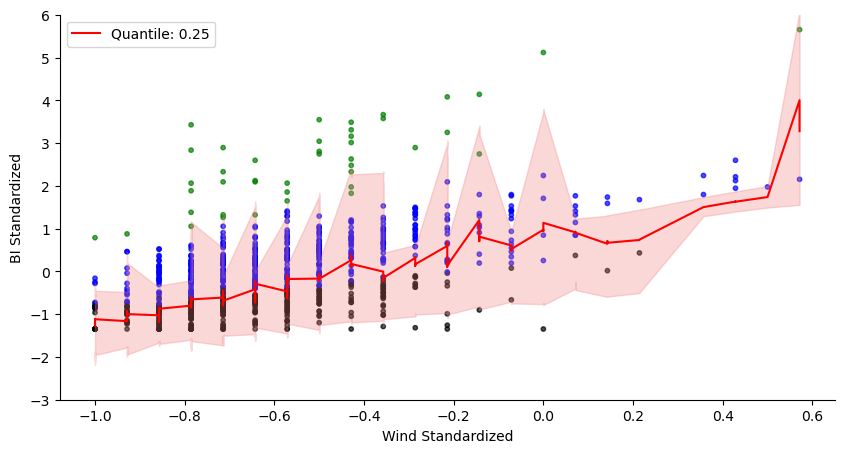

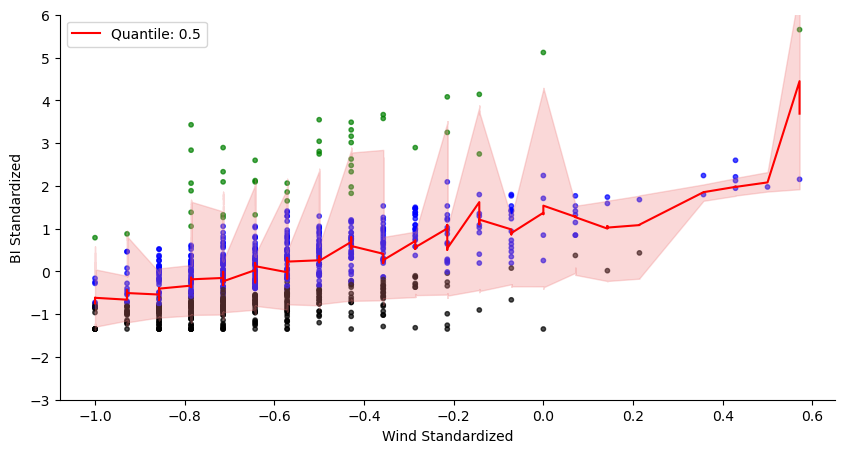

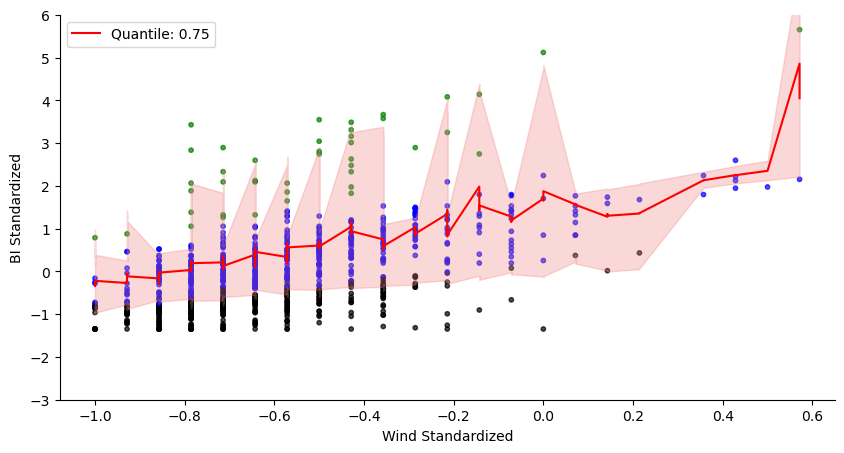

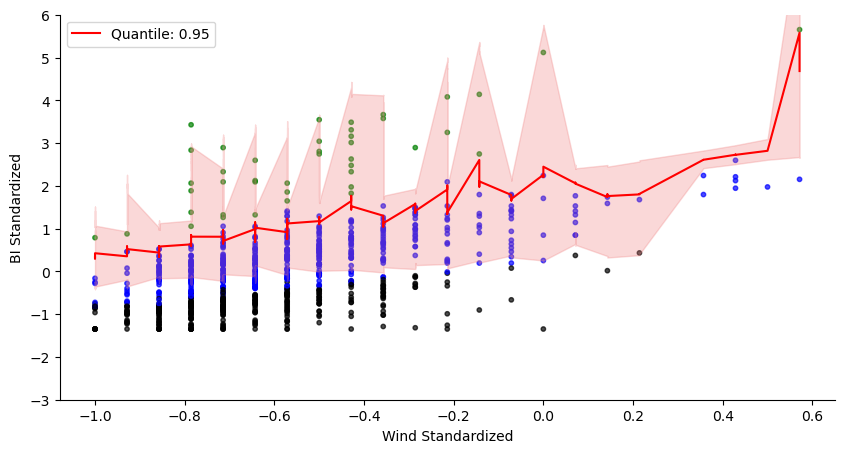

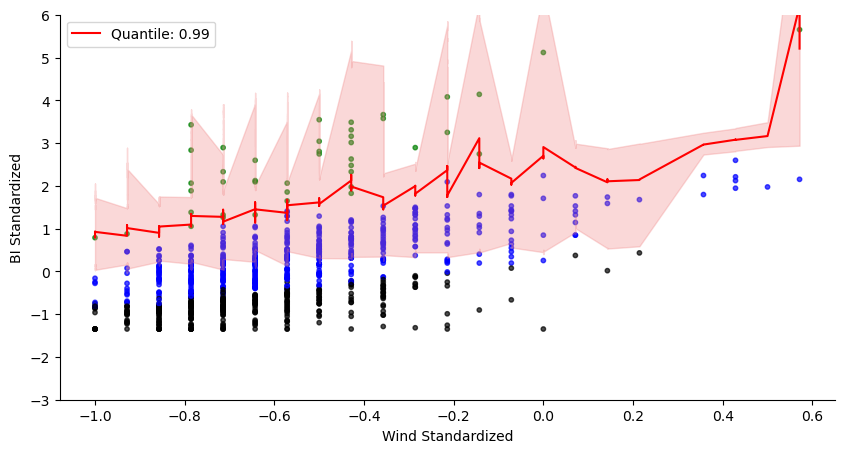

In [232]:
# Same plot but 1 by 1 for saving
wanted_tau_cands = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

for i, wanted_tau in enumerate(wanted_tau_cands):

    fig, ax = plt.subplots(figsize=(10,5))
    
    tau_ids = np.array([np.where(tau_grid==w_t)[0][0] for w_t in [wanted_tau]])
    plot_qtx = Q_sample_collect[:,:, tau_ids].squeeze()

    # Get mean
    mean_Q = plot_qtx.mean(0)
    Q_cis = az.hdi(plot_qtx)

    color_list =['black','blue','green']

    ax.scatter(X_train, y_train,
                s=10, color=[color_list[i] for i in agglo_cluster_solution], alpha=0.7)

    ax.plot(x_vals_arr, mean_Q,alpha=1,lw=1.5, c='red', label=f'Quantile: {wanted_tau}')
    ax.fill_between(x_vals_arr, Q_cis[:,0],
                            Q_cis[:,1], color='lightcoral', alpha=.3)
    

    ax.legend()
    ax.set_ylim([-3,6])
    ax.set_xlabel('Wind Standardized')
    ax.set_ylabel('BI Standardized')
    ax.spines[['right', 'top']].set_visible(False)

    plt.savefig(f'Exp Results/Xu Dataset/Run 2/Wind/mixture_QR_quantile_line_{wanted_tau}.png')

## Extra groups of point regularly co-clustered

- Idea for each cluster extract exemplar points, i.e point that is co-clustered most of often
- Extract beta value for that cluster 

In [233]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

c_id = cluster_ids[1]

# Extract points in that cluster
cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

# Choose k and get top k point
k = int(len(cluster_member_id)*0.05)
point_wise_scores = np.sum(points_sim, 1)
sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k]

cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]

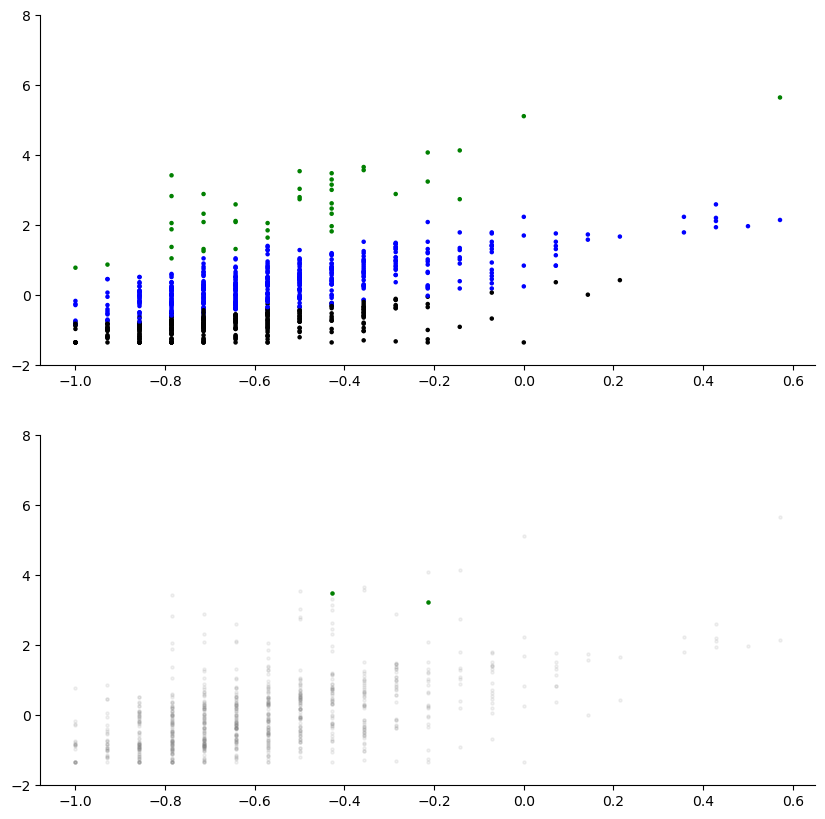

In [234]:
# Plot for sanity check
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].scatter(Xs, Ys, c=[color_list[i] for i in agglo_cluster_solution],alpha=1, s=5)
ax[0].set_ylim([-2,8])
ax[0].spines[['right', 'top']].set_visible(False)


# Plot exemplar
ax[1].scatter(Xs, Ys, c='gray',alpha=0.1, s=5)
ax[1].set_ylim([-2,8])
ax[1].spines[['right', 'top']].set_visible(False)


xs_cluster = Xs[cluster_exemplar_ids]
ys_cluster = Ys[cluster_exemplar_ids]
ax[1].scatter(xs_cluster, ys_cluster, c=color_list[c_id],alpha=1, s=5)


For these exemplar points extract their betas

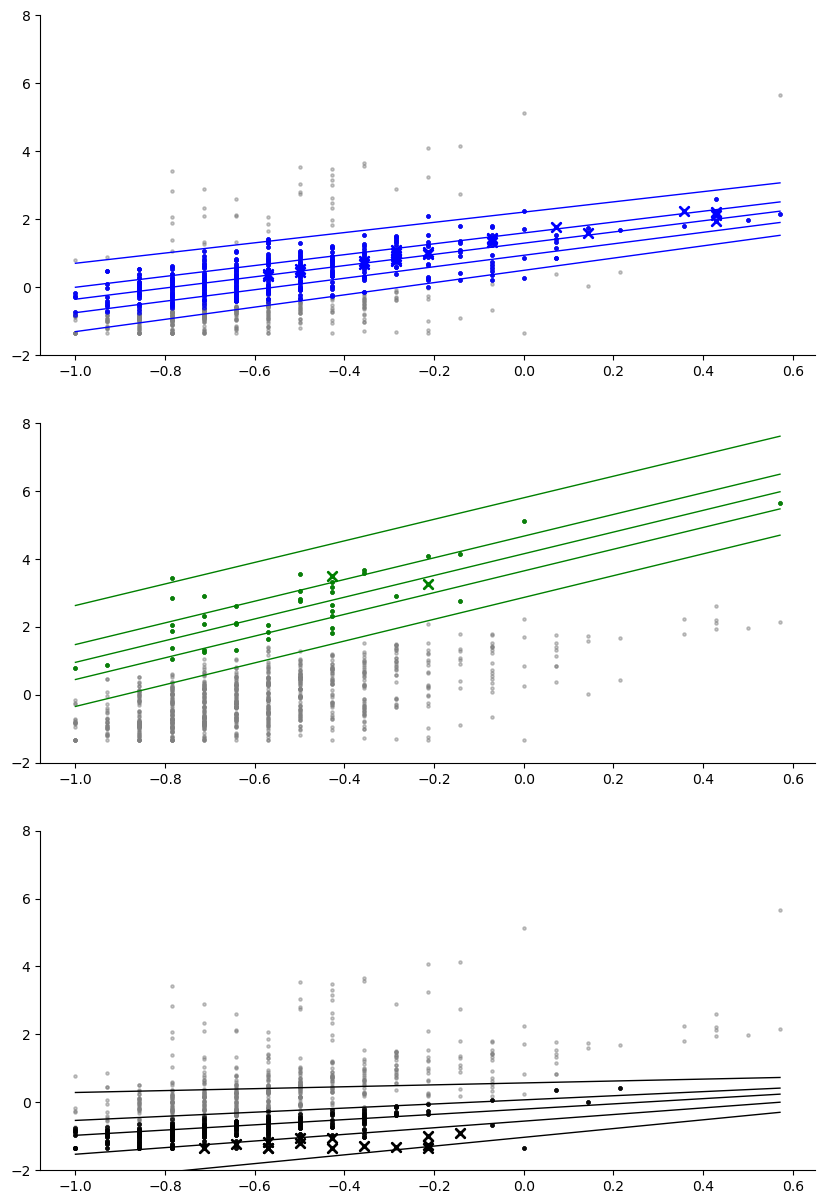

In [239]:

# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(len(cluster_ids), 1, figsize=(10,5*len(cluster_ids)))


for c_id in cluster_ids:
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):

        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_k = phi_samp[k-1]


            # Using phi generate the quantile regression function
            phi_samp_clust = phi_samp[k-1,:]
            m = (len(phi_samp_clust) - 4)// 2
            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1]
            #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
            #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
            sigma_1_current = phi_samp_clust[2*m+2]
            sigma_2_current = phi_samp_clust[2*m+3]
            # Generate quantities

            if prior_on_t:
                v_current = phi_samp_clust[2*m+4]

            else:
                v_current = 1.0

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)

            # Get beta samp
            beta_0_samp = mu_current + (eta_1 + eta_2)/2
            beta_1_samp = gamma_current + (eta_1 - eta_2)/2

            beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)

            beta_weight.append(p_count)



    x_grid = np.linspace(np.min(Xs), np.max(Xs),10)

    beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.vstack([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])

    sample_quantiles = [0.05,0.25,0.5,0.75,0.95]
    sample_quantile_inds = [np.argwhere(tau_grid_expanded==q)[0][0] for q in sample_quantiles]

    for sample_quantile_id in sample_quantile_inds:


        b0_samples = beta_0_expanded[:,sample_quantile_id]
        b1_samples = beta_1_expanded[:,sample_quantile_id]
        
        # Remove possible outliers
        b0_samples = b0_samples[np.abs(b0_samples)<1e5]
        b1_samples = b1_samples[np.abs(b1_samples)<1e5]
        
        b0_mean = b0_samples.mean()
        b1_mean = b1_samples.mean()
        y_vals = b0_mean + b1_mean * x_grid

        # Plot exemplar
        ax[c_id-1].scatter(Xs, Ys, c='gray',alpha=0.1, s=5)
        ax[c_id-1].set_ylim([-2,8])
        ax[c_id-1].spines[['right', 'top']].set_visible(False)

        xs_cluster = Xs[cluster_member_id]
        ys_cluster = Ys[cluster_member_id]

        xs_cluster_exemplar = Xs[cluster_exemplar_ids]
        ys_cluster_exemplar = Ys[cluster_exemplar_ids]
        ax[c_id-1].scatter(xs_cluster, ys_cluster, c=color_list[c_id],alpha=0.5, s=5)
        ax[c_id-1].scatter(xs_cluster_exemplar, ys_cluster_exemplar, c=color_list[c_id],alpha=1,
                   s=50, marker='x')

        ax[c_id-1].plot(x_grid, y_vals, c=color_list[c_id],alpha=1, lw=1)

plt.savefig(f'Exp Results/Xu Dataset/Run 2/Wind/Exemplar_Reg.png')
plt.show()

Plot Beta Information

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/3786128081.py:118: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/3786128081.py:119: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/3786128081.py:118: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_68573/3786128081.py:119: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/var/folders/0p/10_vdl_n

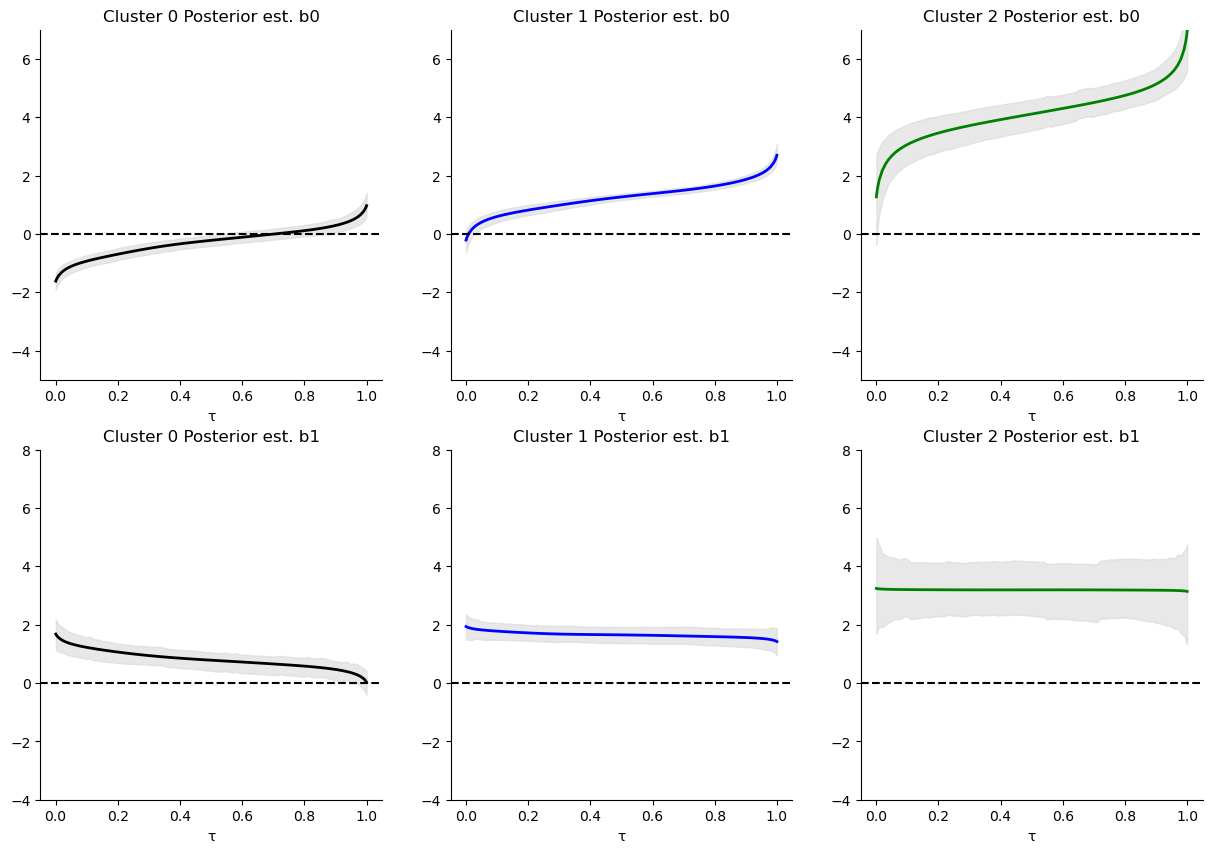

In [240]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(2, len(cluster_ids), figsize=(5*len(cluster_ids),10))

for c_id in np.sort(cluster_ids):
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):

        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_k = phi_samp[k-1]


            # Using phi generate the quantile regression function
            phi_samp_clust = phi_samp[k-1,:]
            m = (len(phi_samp_clust) - 4)// 2
            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1]
            #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
            #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
            sigma_1_current = phi_samp_clust[2*m+2]
            sigma_2_current = phi_samp_clust[2*m+3]
            # Generate quantities

            if prior_on_t:
                v_current = phi_samp_clust[2*m+4]

            else:
                v_current = 1.0

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)

            # Get beta samp
            beta_0_samp = mu_current + (eta_1 + eta_2)/2
            beta_1_samp = gamma_current + (eta_1 - eta_2)/2

            beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)

            beta_weight.append(p_count)



    x_grid = np.linspace(np.min(Xs), np.max(Xs),10)

    beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.vstack([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])
    
    # Remove anomaly values
    beta_0_expanded = beta_0_expanded * (np.abs(beta_0_expanded) < 1e3).astype('float')
    beta_1_expanded = beta_1_expanded * (np.abs(beta_1_expanded) < 1e3).astype('float')

    
    b0_c_mean = np.mean(beta_0_expanded,0)
    b1_c_mean = np.mean(beta_1_expanded,0)
    
    
    # Get CIs
    b0_cis = az.hdi(beta_0_expanded)
    b1_cis = az.hdi(beta_1_expanded)


    # Plot values
    # Beta 0
    ax[0,c_id].plot(tau_grid, b0_c_mean, color=color_list[c_id],lw=2)
    ax[0,c_id].fill_between(tau_grid, b0_cis[:,0],
                    b0_cis[:,1], color='lightgray', alpha=.5)

    # Beta 1
    ax[1,c_id].plot(tau_grid, b1_c_mean, color=color_list[c_id],lw=2)
    ax[1,c_id].fill_between(tau_grid, b1_cis[:,0],
                    b1_cis[:,1], color='lightgray', alpha=.5)

    ax[0,c_id].title.set_text(f"Cluster {c_id} Posterior est. b0")
    ax[1,c_id].title.set_text(f"Cluster {c_id} Posterior est. b1")

    ax[0,c_id].set_xlabel('τ')
    ax[1,c_id].set_xlabel('τ')

    ax[0, c_id].axhline(y=0,linestyle='--', c = 'black')
    ax[1, c_id].axhline(y=0,linestyle='--', c = 'black')
    
    ax[0, c_id].set_ylim([-5,7])
    ax[1, c_id].set_ylim([-4,8])
    
    ax[0, c_id].spines[['right', 'top']].set_visible(False)
    ax[1, c_id].spines[['right', 'top']].set_visible(False)
    
plt.savefig(f'Exp Results/Xu Dataset/Run 2/Wind/Exemplar_slopes.png')
plt.show()

In [121]:
np.sum(beta_1_expanded[:,0]<-1000000)

array([1.72900548, 1.72644589, 1.72180077, ..., 3.90912648, 3.90041148,
       3.8957821 ])

In [110]:
len(beta_1_expanded[:,0])

43978

In [111]:
beta_1_expanded[:,0].mean()

-11072.88653618723

In [474]:
X_covar = wildfire_df_xu_sub[["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]].values

In [485]:
np.eye(X_p)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [503]:
X_p = X_covar.shape[1]

# Sample initial projection alpha
X_alpha = multivariate_t.rvs(loc=np.zeros(X_p), shape=np.eye(X_p), df=1)

if len(X_covar.shape) > 1:
    if X_covar.shape[1] > 1:
        
        # Initial projection to calculate a and b
        init_proj = (X_covar @ X_alpha)
        
        # Calc a
        X_a = (max(init_proj) + min(init_proj))/2
        X_b = (max(init_proj) - min(init_proj))/2
        
        X_proj = (init_proj - X_a)/X_b

In [506]:
def project_x(X_covar, X_alpha):
    """
    X_covar: n x p covariate matrix (not including intercept!)
    X_lpha: p dim projection vector (randomly sampled)
    """
    
    if X_covar.shape == 1:
        print("Error")
    if X_covar.shape[1]==1:
        print("Error")
    # Initial projection to calculate a and b
    init_proj = (X_covar @ X_alpha)

    # Calc a
    X_a = (max(init_proj) + min(init_proj))/2
    # Calc b
    X_b = (max(init_proj) - min(init_proj))/2

    # Calc final projection
    X_proj = (init_proj - X_a)/X_b
    
    return X_proj
    

In [571]:
x_vals = Xs
x_vals_multi = np.vstack([Xs,Xs,Xs,Xs]).T
x_alpha_current = np.array([0.5,0.5,0.5,0.5])
gamma = np.array([0.5,0.5,0.5,0.5])

In [576]:
np.expand_dims(x_vals_multi @ gamma, -1)

array([[1.05263158],
       [0.84210526],
       [0.77192982],
       [1.15789474],
       [1.78947368],
       [1.22807018],
       [0.73684211],
       [0.94736842],
       [1.05263158],
       [1.19298246],
       [0.52631579],
       [1.36842105],
       [1.05263158],
       [0.94736842],
       [0.87719298],
       [0.87719298],
       [0.77192982],
       [1.05263158],
       [0.94736842],
       [0.59649123],
       [0.94736842],
       [0.77192982],
       [0.77192982],
       [1.54385965],
       [0.73684211],
       [0.42105263],
       [1.29824561],
       [1.29824561],
       [1.15789474],
       [1.26315789],
       [0.77192982],
       [0.70175439],
       [1.43859649],
       [1.26315789],
       [0.77192982],
       [0.9122807 ],
       [0.87719298],
       [1.33333333],
       [0.70175439],
       [1.19298246],
       [0.80701754],
       [1.47368421],
       [1.47368421],
       [1.0877193 ],
       [0.70175439],
       [0.9122807 ],
       [1.22807018],
       [1.964

In [564]:
x_vals_multi.shape

(800, 4)

In [570]:
(gamma * np.expand_dims(x_vals, -1)).shape

(800, 1)

In [552]:
mu=0.5
gamma=0.5

In [577]:
Q_tx  = mu + np.expand_dims(x_vals_multi @ gamma, -1) + \
        np.expand_dims((1-x_vals)/2, -1) *eta_1 + \
        np.expand_dims((1+x_vals)/2, -1) *eta_2

In [578]:
Q_tx.shape

(800, 108)

In [557]:
np.expand_dims(x_vals, -1).shape

(800, 1)

In [579]:
p_test = np.array([0.1,0.5,10,2])

In [606]:
np.sum([t.logpdf(ga_i,df=1,loc=0,scale=1) for ga_i in p_test])

-11.036571854840338

In [607]:
multivariate_t.logpdf(p_test,loc = np.zeros(4),
                    shape=np.eye(4),
                    df=1) 

-14.218225543964664

In [605]:
 np.array([t.rvs(df=1,loc=0,scale=1) for _ in range(4)])

array([-0.31579846,  1.97446789, -1.21032876, -0.47881502])

In [611]:
p_test[1:3]

array([ 0.5, 10. ])

In [495]:
(X_covar @ X_alpha)

array([-2.00397615, -0.97161642, -4.2624894 , -4.07144426, -3.85191497,
       -0.71321973, -4.26469902, -0.19420897, -4.51204147, -2.53804521,
        0.38100882, -3.51911344, -2.50423907, -3.47755987, -5.53090779,
       -2.22822922, -5.54090436, -5.21611736, -1.53139885, -0.9774595 ,
       -5.28692202, -4.27442789, -4.35782916, -4.30562211, -3.23375793,
       -4.2683359 , -1.3762349 , -4.57806963, -3.23706909, -3.7879913 ,
       -0.80078618, -4.20551563, -2.69695601, -0.68827805,  0.71844007,
       -2.92839951, -0.20897575, -1.31641615,  1.4011107 , -5.66191342,
       -5.3180075 , -2.31494633, -3.79533819, -5.77384301, -4.8278079 ,
       -4.3118962 , -3.57307804, -4.29496843, -0.7389941 , -1.36172422,
       -3.73084739, -3.85753872, -1.8654799 , -1.18762403, -2.02550034,
       -0.83061481, -1.6770322 , -1.87000328, -5.14113867, -0.70558315,
       -4.12650347, -1.58926528, -2.23674037, -2.35640168, -3.75347211,
       -4.84963428, -3.85196763, -2.27228816, -3.8305141 ,  0.96

In [470]:
Xs.shape

(800,)

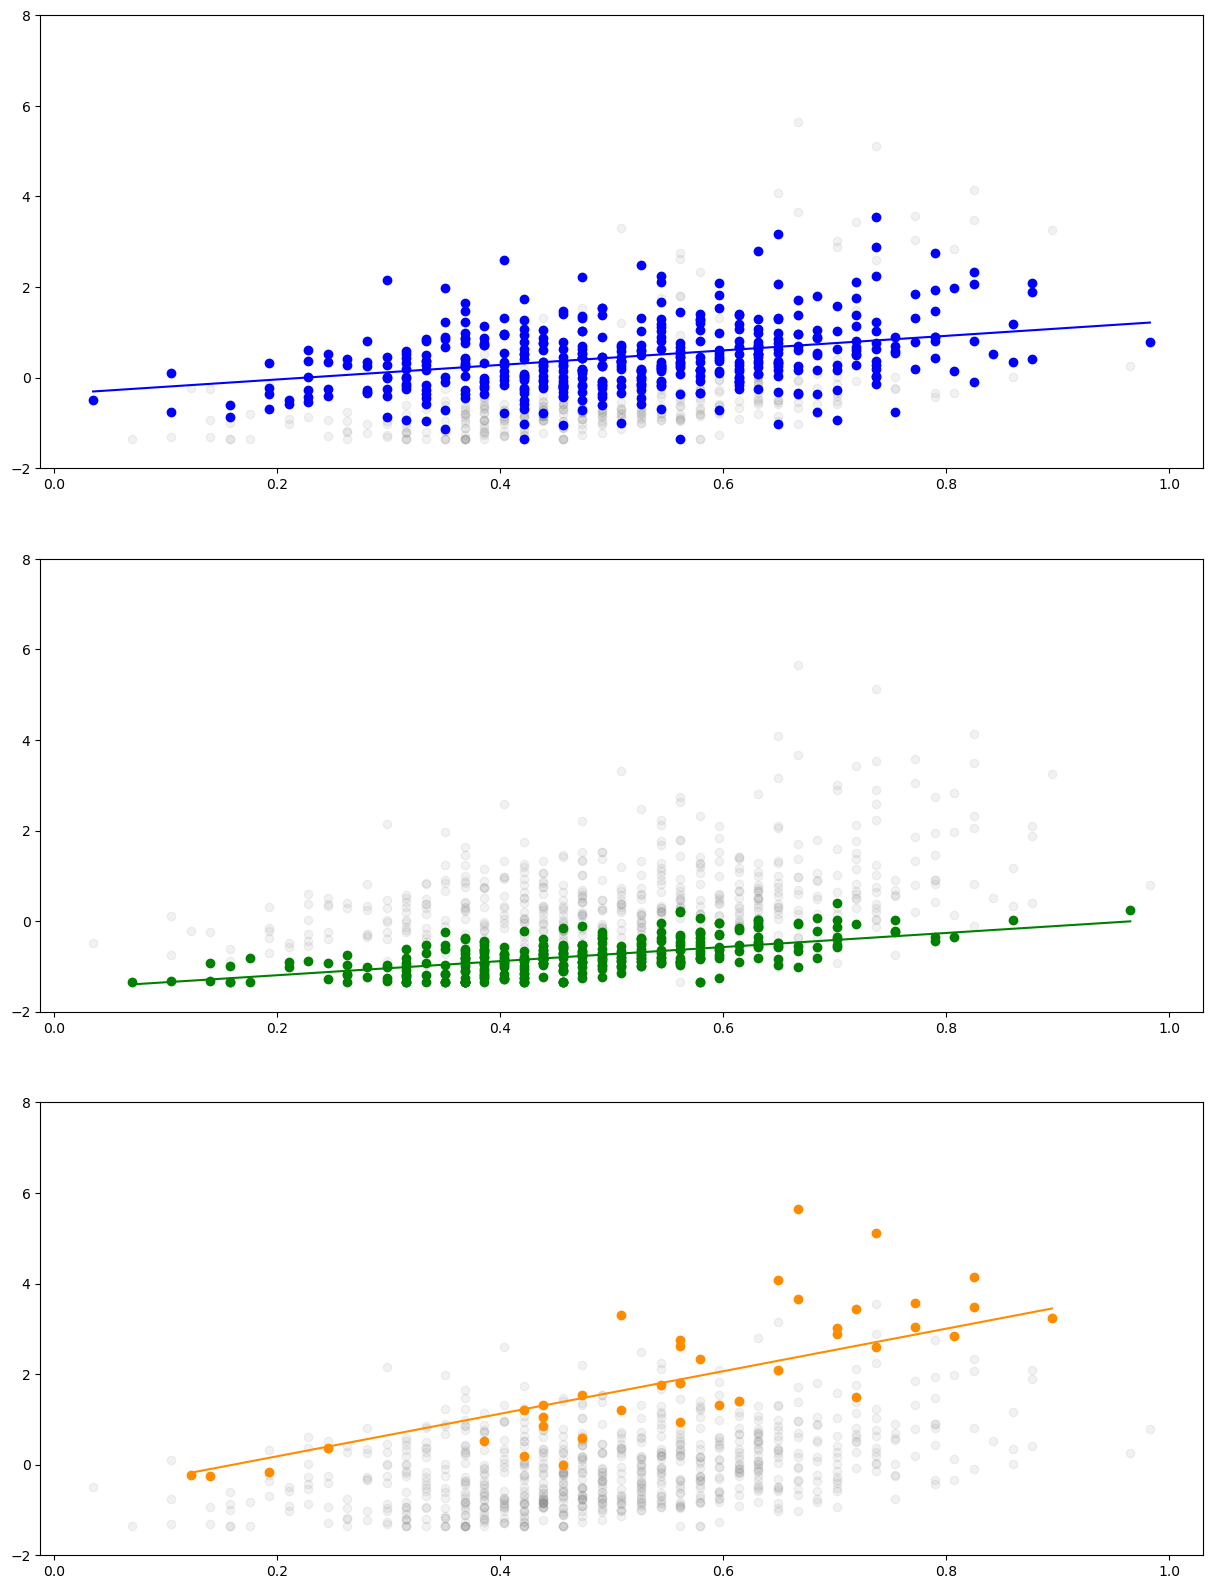

In [270]:
color_list = ['red','blue',
            'green','darkorange','black','purple','brown']

sample_quantiles = [0.5]#[0.01,0.05,0.25,0.5,0.75,0.95,0.99]#[0.05, 0.25, 0.5, 0.75, 0.95]
sample_quantile_inds = [np.argwhere(tau_grid_expanded==q)[0][0] for q in sample_quantiles]
# Split into clusters

sample_id = 300
partition_samp = partition_save[sample_id]
# Get phi samp
phi_samp = phi_save[sample_id]

x_vals_arr = []
output_q_tx = []
# Iterate through each cluster
n_clust = len(np.unique(partition_samp))
fig, ax = plt.subplots(n_clust,1,figsize=(n_clust*5,20))

for j,k in enumerate(np.unique(partition_samp)):

    # Extract data points + phi_k
    phi_k = phi_samp[k-1]

    point_ids = np.where(partition_samp==k)[0]

    # Extract X Values
    x_vals_k = Xs[point_ids]
    # Extract y values
    y_vals_k = Ys[point_ids]

    # Using phi generate the quantile regression function
    phi_samp_clust = phi_samp[k-1,:]
    m = (len(phi_samp_clust) - 4)// 2
    w1_knot_points_current = phi_samp_clust[0:m]
    w2_knot_points_current = phi_samp_clust[m:2*m]
    mu_current = phi_samp_clust[2*m]
    gamma_current = phi_samp_clust[2*m+1]
    #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
    #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
    sigma_1_current = phi_samp_clust[2*m+2]
    sigma_2_current = phi_samp_clust[2*m+3]
    # Generate quantities
    
    if prior_on_t:
        v_current = phi_samp_clust[2*m+4]

    else:
        v_current = 1.0
        
    # Generate sample of GP approx
    w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                            a_kappa=alpha_kappa,
                                                                            b_kappa=beta_kappa,
                                                                            tau_grid=tau_grid_expanded,
                                                                            A_g_matrices=A_matrices_G,
                                                                            cov_mat_knot_store=cov_matrices_G,
                                                                            lambda_grid_log_prob=lambda_grid_log_prob)

    w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                            a_kappa=alpha_kappa,
                                                                            b_kappa=beta_kappa,
                                                                            tau_grid=tau_grid_expanded,
                                                                            A_g_matrices=A_matrices_G,
                                                                            cov_mat_knot_store=cov_matrices_G,
                                                                            lambda_grid_log_prob=lambda_grid_log_prob)

    # Generate Q
    eta_1  = eta_function_i_vector(tau_input=tau_grid,
                        w_vals=w1_approx_current,
                        tau_grid=tau_grid_expanded,
                        mean=0.0,
                        sd=1.0,
                        v=v_current,
                        sigma=sigma_1_current,
                        dist=quantile_dist)

    eta_2  = eta_function_i_vector(tau_input=tau_grid,
                        w_vals=w2_approx_current,
                        tau_grid=tau_grid_expanded,
                        mean=0.0,
                        sd=1.0,
                        v=v_current,
                        sigma=sigma_2_current,
                        dist=quantile_dist)

    Q_tx  = mu_current + gamma_current * np.expand_dims(x_vals_k, -1) + \
        np.expand_dims((1-x_vals_k)/2, -1) * eta_1 + \
        np.expand_dims((1+x_vals_k)/2, -1) * eta_2
    
    beta_0_samp = mu_current + (eta_1 + eta_2)/2
    beta_1_samp = gamma_current + (eta_1 - eta_2)/2
    
    
    # Generate prediction and plot
    x_vals_arranged_k = np.sort(x_vals_k)
    y_pred_samples = np.array([b0 + b1*x_vals_arranged_k for b0,b1 in zip(beta_0_samp, beta_1_samp)])

    #ax[i].plot(X_train, y_pred_samples.mean(0), color='red')
    
    for q_id in sample_quantile_inds:
        # Extract y_preds
        y_pred_samples_plot = y_pred_samples[q_id,:]
        
        if n_clust > 1:
            ax[j].scatter(Xs, Ys, c='gray',alpha=0.1)
            ax[j].plot(x_vals_arranged_k, y_pred_samples_plot, c=color_list[j+1])
            ax[j].scatter(x_vals_k, y_vals_k, c=color_list[j+1])

            ax[j].set_ylim([-2,8])
        else:
            ax.scatter(Xs, Ys, c='gray',alpha=0.1)
            ax.plot(x_vals_arranged_k, y_pred_samples_plot, c=color_list[j+1])
            ax.scatter(x_vals_k, y_vals_k, c=color_list[j+1])

            ax.set_ylim([-2,8])

    output_q_tx.append(Q_tx)
    x_vals_arr.append(x_vals_k)

output_q_tx = np.concatenate(output_q_tx,0)
x_vals_arr = np.concatenate(x_vals_arr,0)

In [ ]:
Q_sample_collect = []
x_vals_checker = []
omitted_samps = 0
omitted_samp_id = []
omitted_samp_out = []
#bad_samps1 = np.where(np.min(np.min(Q_sample_collect,1),1)<-30)[0]
#bad_samps2 = np.where(np.min(np.min(Q_sample_collect,1),1)>30)[0]


for i in range(n_gibbs-1):#range(n_gibbs-1): # range(n_gibbs-1):
    
    #if (i in bad_samps1) or (i in bad_samps2):
     #   continue
    
    # Get cluster
    partition_samp = partition_save[i]

    # Get phi samp
    phi_samp = phi_save[i]

    output_q_tx = []
    x_vals_arr = []
    # Iterate through each cluster
    for k in np.unique(partition_samp):

        # Extract data points + phi_k
        phi_k = phi_samp[k-1]

        point_ids = np.where(partition_samp==k)[0]

        # Extract X Values
        x_vals_k = X_train[point_ids]

        # Using phi generate the quantile regression function
        phi_samp_clust = phi_samp[k-1,:]
        m = (len(phi_samp_clust) - 4)// 2
        w1_knot_points_current = phi_samp_clust[0:m]
        w2_knot_points_current = phi_samp_clust[m:2*m]
        mu_current = phi_samp_clust[2*m]
        gamma_current = phi_samp_clust[2*m+1]
        #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
        #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
        sigma_1_current = phi_samp_clust[2*m+2]
        sigma_2_current = phi_samp_clust[2*m+3]
        
        if prior_on_t:
            v_current = phi_samp_clust[2*m+4]
        else:
            v_current = 1.0
        # Generate quantities
        
        # Generate sample of GP approx
        w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)

        w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)
        
        # Generate Q
        eta_1  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w1_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_1_current,
                            dist=quantile_dist)

        eta_2  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w2_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_2_current,
                            dist=quantile_dist)
        
        Q_tx  = mu_current + gamma_current * np.expand_dims(x_vals_k, -1) + \
            np.expand_dims((1-x_vals_k)/2, -1) * eta_1 + \
            np.expand_dims((1+x_vals_k)/2, -1) * eta_2
        
        beta_0_samp = mu_current + (eta_1 + eta_2)/2
        beta_1_samp = gamma_current + (eta_1 - eta_2)/2
        
        Q_tx_alt = np.array([b0 + b1*x_vals_k for b0,b1 in zip(beta_0_samp, beta_1_samp)])
        
        output_q_tx.append(Q_tx_alt.T)
        x_vals_arr.append(x_vals_k)

    output_q_tx = np.concatenate(output_q_tx,0)
    x_vals_arr = np.concatenate(x_vals_arr,0)
    
    sort_ids = np.argsort(x_vals_arr)
    x_vals_arr = x_vals_arr[sort_ids]
    output_q_tx = output_q_tx[sort_ids,:]
    
    # Optional
    if (np.max(output_q_tx) > 1e9) or (np.min(output_q_tx)<-1e9):
        omitted_samps += 1
        omitted_samp_id.append(i)
        omitted_samp_out.append(output_q_tx)
        #continue
    
    Q_sample_collect.append(output_q_tx)
    x_vals_checker.append(x_vals_arr)

Q_sample_collect = [Q.reshape(1,len(X_train),len(tau_grid)) for Q in Q_sample_collect]
Q_sample_collect = np.concatenate(Q_sample_collect,0)

In [93]:
greek_letterz=[chr(code) for code in range(945,970)]

print(greek_letterz)


['α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω']


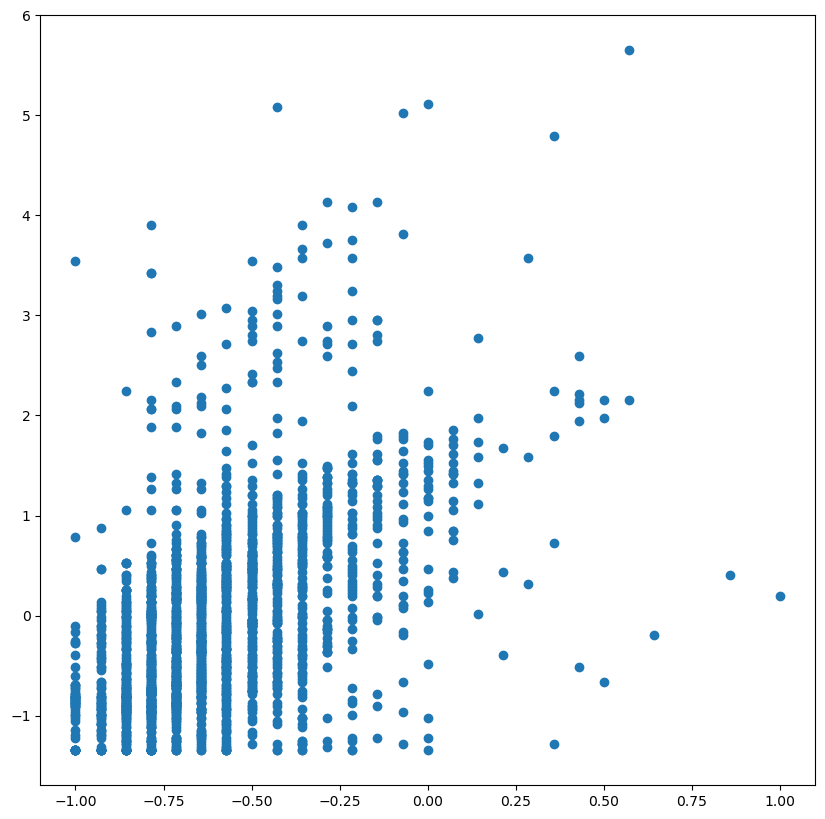

In [94]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(X_train, y_train)